# NicheCompass Data Analysis

- **Creator**: Sebastian Birk (<sebastian.birk@helmholtz-munich.de>).
- **Affiliation:** Helmholtz Munich, Institute of Computational Biology (ICB), Talavera-López Lab
- **Date of Creation:** 22.01.2023
- **Date of Last Modification:** 07.07.2023

- In order to run this notebook, a trained model needs to be stored under f"../artifacts/{dataset}/models/{model_label}/{load_timestamp}".

## 1. Setup

### 1.1 Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../utils")

In [3]:
import argparse
import os
import random
import warnings
from datetime import datetime

import anndata as ad
import matplotlib
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.sparse as sp
import scipy.stats as stats
import seaborn as sns
import squidpy as sq
import torch
from matplotlib import gridspec
from matplotlib.pyplot import rc_context

from nichecompass.models import NicheCompass
from nichecompass.utils import (add_gps_from_gp_dict_to_adata,
                                aggregate_obsp_matrix_per_cell_type,
                                create_cell_type_chord_plot_from_df,
                                generate_enriched_gp_info_plots)

from color_utils import (create_new_color_dict,
                         batch_colors,
                         latent_cluster_colors,
                         mapping_entity_colors,
                         seqfish_mouse_organogenesis_cell_type_colors,
                         spatial_atac_rna_seq_mouse_embryo_and_brain_rna_colors,
                         spatial_atac_rna_seq_mouse_embryo_and_brain_atac_colors,
                         starmap_plus_mouse_cns_cell_type_colors,
                         visium_human_heart_colors,
                         vizgen_merfish_human_ovarian_cancer_cell_type_colors)
from analysis_utils import (add_cell_type_latent_cluster_emphasis,
                            add_sub_cell_type,
                            compute_cell_type_latent_clusters,
                            generate_gp_info_plots,
                            plot_physical_latent_for_cell_types,
                            plot_cell_type_latent_clusters,
                            plot_latent,
                            plot_category_in_latent_and_physical_space,
                            store_top_gps_summary)

/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/h

### 1.2 Define Parameters

In [5]:
# dataset = "spatial_atac_rna_seq_mouse_brain_batch2"
dataset = "seqfish_mouse_organogenesis_imputed"
# dataset = "vizgen_merfish_human_colon_cancer"
# dataset = "vizgen_merfish_human_ovarian_cancer"
# dataset = "vizgen_merfish_human_lung_cancer"
# dataset = "nanostring_cosmx_human_nsclc"
# dataset = "starmap_plus_mouse_cns"
# dataset = "xenium_human_breast_cancer"

#### 1.2.1 Generic Parameters

In [6]:
## Model
# AnnData keys
adj_key = "spatial_connectivities"
spatial_key = "spatial"
sub_cell_type_key = "sub_cell_type"
gp_names_key = "nichecompass_gp_names"
active_gp_names_key = "nichecompass_active_gp_names"
latent_key = "nichecompass_latent"
mapping_entity_key = "mapping_entity"

## Analysis
differential_gp_test_results_key = "nichecompass_differential_gp_test_results"

## Others
random_seed = 0

#### 1.2.2 Dataset-specific Parameters

In [11]:
multimodal = False
log_norm_omics_features = False
cell_type_groups = []
latent_groups = []

if dataset == "seqfish_mouse_organogenesis_imputed":
    load_timestamp = "12062023_192956"
    load_timestamp = "28062023_091941_1"
    load_timestamp = "06072023_171526_3"
    model_label = "one-hop-norm_reference"
    counts_key = "log_normalized_counts"
    cell_type_key = "celltype_mapped_refined"
    cell_type_colors = seqfish_mouse_organogenesis_cell_type_colors
    dataset_str = "seqFISH Mouse Organogenesis Imputed"
    multimodal = False
    sample_key = "sample"
    condition_key = "batch"
    latent_leiden_resolution = 0.2
    spot_size = 0.03
    cell_type_groups = []
    latent_groups = []
    multimodal = False
elif dataset == "starmap_plus_mouse_cns":
    cell_type_key = "Main_molecular_cell_type"
    cell_type_colors = starmap_plus_mouse_cns_cell_type_colors
    groups = "Astrocytes"
    dataset_str = "STARmap PLUS Mouse Central Nervous System"
    load_timestamp = "03062023_152505"
    load_timestamp = "12062023_110439"
    load_timestamp = "20062023_164533_42"
    model_label = "one-hop-norm_reference"
    condition_key = "batch"
    sample_key = "batch"
    latent_leiden_resolution = 0.2
    latent_cluster_spot_size = 0.2
    multimodal = False
    spot_size=0.2
    cell_type_groups = ["Microglia", "Pericytes"]
elif dataset == "visium_human_heart":
    load_timestamp = "15052023_102158"
    cell_type_key = "majority_cell_type"
    cell_type_colors = visium_human_heart_colors
    dataset_str = "Visium Human Heart"
    sample_key = "batch"
    samples = ["batch1", "batch2", "batch3"]
    condition_key = "batch"
    latent_leiden_resolution = 0.5
    latent_cluster_key = f"latent_leiden_{str(latent_leiden_resolution)}"
    latent_cluster_spot_size = 200
elif dataset == "spatial_atac_rna_seq_mouse_brain_batch2":
    load_timestamp = "02062023_151955"
    model_label = "one-hop-norm_reference"
    cell_type_key = "RNA_clusters"
    rna_cluster_key = "RNA_clusters"
    atac_cluster_key = "ATAC_clusters"
    cell_type_colors = spatial_atac_rna_seq_mouse_embryo_and_brain_rna_colors
    rna_cluster_colors = spatial_atac_rna_seq_mouse_embryo_and_brain_rna_colors
    atac_cluster_colors = spatial_atac_rna_seq_mouse_embryo_and_brain_atac_colors
    dataset_str = "Spatial ATAC-RNA-Seq Mouse Brain"
    sample_key = "batch"
    samples = ["p22"]
    condition_key = "batch"
    latent_leiden_resolution = 0.6
    latent_cluster_spot_size = 30
    latent_groups = []
    multimodal = True
    spot_size = 30
    cell_type_groups = []
    latent_groups = ["1", "6", "7", "5", "3"]
elif dataset == "nanostring_cosmx_human_nsclc":
    load_timestamp = "12062023_123411"
    load_timestamp = "12062023_123012"
    load_timestamp = "29062023_090719_2"
    model_label = "one-hop-norm_reference"
    dataset_str = "Nanostring CosMx Human NSCLC"
    condition_key = "batch"
    latent_leiden_resolution = 0.5
    latent_cluster_spot_size = 60
    sample_key = "batch"
    multimodal = False
    spot_size = 50
    cell_type_key = "cell_type"
elif dataset == "vizgen_merfish_human_colon_cancer":
    load_timestamp = "22052023_132110"
    model_label = "one-hop-norm_reference"
    dataset_str = "Vizgen MERFISH Human Colon Cancer"
    condition_key = "sample"
    sample_key = "batch"
    samples = ["batch1", "batch2"]
    latent_leiden_resolution = 0.5
    latent_cluster_spot_size = 30
elif dataset == "vizgen_merfish_human_ovarian_cancer":
    load_timestamp = "13062023_131002"
    load_timestamp = "22052023_132125"
    model_label = "one-hop-norm_reference"
    latent_leiden_resolution = 0.2
    latent_cluster_spot_size = 0.03
    dataset_str = "Vizgen MERFISH Human Ovarian Cancer"
    condition_key = "batch"
    sample_key = "batch"
    spot_size = 30
    cell_type_key = "cell_type"
    cell_type_colors = vizgen_merfish_human_ovarian_cancer_cell_type_colors
elif dataset == "vizgen_merfish_human_lung_cancer":
    load_timestamp = "13062023_131002"
    load_timestamp = "19062023_140621_1"
    model_label = "one-hop-norm_reference"
    latent_leiden_resolution = 0.2
    latent_cluster_spot_size = 0.03
    dataset_str = "Vizgen MERFISH Human Lung Cancer"
    condition_key = "batch"
    sample_key = "batch"
    spot_size = 30
    cell_type_key = "cell_type"
    cell_type_colors = vizgen_merfish_human_ovarian_cancer_cell_type_colors
elif dataset == "xenium_human_breast_cancer":
    load_timestamp = "20062023_165327_6" # 12 neighbors
    # load_timestamp = "20062023_120357_1" # 4 neighbors
    model_label = "one-hop-norm_reference"
    latent_leiden_resolution = 0.2
    latent_cluster_spot_size = 0.03
    dataset_str = "Xenium Human Breast Cancer"
    condition_key = "batch"
    sample_key = "batch"
    spot_size = 30
    cell_type_key = "cell_states"
    
latent_cluster_key = f"latent_leiden_{str(latent_leiden_resolution)}"

### 1.3 Run Notebook Setup

In [12]:
sc.set_figure_params(figsize=(6, 6))
sns.set_style("whitegrid", {'axes.grid' : False})

In [13]:
# Ignore future warnings and user warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)

### 1.4 Configure Paths and Create Directories

In [14]:
# Define paths
figure_folder_path = f"../artifacts/{dataset}/figures/{model_label}/{load_timestamp}"
model_folder_path = f"../artifacts/{dataset}/models/{model_label}/{load_timestamp}"
result_folder_path = f"../artifacts/{dataset}/results/{model_label}/{load_timestamp}"
gp_data_folder_path = "../datasets/gp_data" # gene program data
srt_data_folder_path = "../datasets/srt_data" # spatially resolved transcriptomics data
srt_data_gold_folder_path = f"{srt_data_folder_path}/gold"

# Create required directories
os.makedirs(figure_folder_path, exist_ok=True)
os.makedirs(result_folder_path, exist_ok=True)

## 2. Model

### 2.1 Load Model

In [15]:
if model_label == "sample_integration_method_benchmarking":
    model_folder_path = f"{model_folder_path}/run{run_number}"

In [16]:
if multimodal:
    model = NicheCompass.load(dir_path=model_folder_path,
                              adata=None,
                              adata_file_name=f"{dataset}_{model_label}.h5ad",
                              adata_atac=None,
                              adata_atac_file_name=f"{dataset}_{model_label}_atac.h5ad",
                              gp_names_key=gp_names_key)
else:
    # Load trained model
    model = NicheCompass.load(dir_path=model_folder_path,
                              adata=None,
                              adata_file_name=f"{dataset}_{model_label}.h5ad",
                              gp_names_key=gp_names_key)

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, gene_expr_recon_dist: nb
NODE LABEL METHOD -> one-hop-norm
ACTIVE GP THRESHOLD RATIO -> 0.0
LOG VARIATIONAL -> True
CATEGORICAL COVARIATES EMBEDDINGS INJECTION -> ['gene_expr_decoder']
ENCODER -> n_input: 4032, n_cat_covariates_embed_input: 0, n_layers: 1, n_hidden: 1540, n_latent: 1540, n_addon_latent: 0, conv_layer: gcnconv, n_attention_heads: 0, dropout_rate: 0.0
COSINE SIM GRAPH DECODER -> dropout_rate: 0.0
MASKED GENE EXPRESSION DECODER -> n_input: 1540, n_cat_covariates_embed_input: 3, n_addon_input: 0, n_output: 8064
ONE HOP GCN NORM NODE LABEL AGGREGATOR


## 3. Analysis

In [17]:
# Check number of active gene programs
active_gps = model.get_active_gps()
print(f"Number of total gene programs: {len(model.adata.uns[gp_names_key])}.")
print(f"Number of active gene programs: {len(active_gps)}.")

Number of total gene programs: 1540.
Number of active gene programs: 1540.


In [18]:
gp_summary_df = model.get_gp_summary()
gp_summary_df[gp_summary_df["gp_active"] == True][0:20]

gp_name  all_gp_idx  gp_active  active_gp_idx  \
0      EPOR_ligand_receptor_GP           0       True              0   
1      TP53_ligand_receptor_GP           1       True              1   
2       TNF_ligand_receptor_GP           2       True              2   
3     PTPN6_ligand_receptor_GP           3       True              3   
4      NPPA_ligand_receptor_GP           4       True              4   
5      CCL4_ligand_receptor_GP           5       True              5   
6    CXCL12_ligand_receptor_GP           6       True              6   
7       KIT_ligand_receptor_GP           7       True              7   
8       EGF_ligand_receptor_GP           8       True              8   
9       IL2_ligand_receptor_GP           9       True              9   
10    EFNB1_ligand_receptor_GP          10       True             10   
11     AGER_ligand_receptor_GP          11       True             11   
12     FRS3_ligand_receptor_GP          12       True             12   
13   S100A1_ligand_receptor_GP          13       True             13   
14    GSTO1_ligand_receptor_GP          14       True             14   
15     POMC_ligand_receptor_GP          15       True             15   
16  MT-RNR2_ligand_receptor_GP          16       True             16   
17      PYY_ligand_receptor_GP          17       True             17   
18   NOTCH1_ligand_receptor_GP          18       True             18   
19      FAS_ligand_receptor_GP          19       True             19   

    n_source_genes  n_non_zero_source_genes  n_target_genes  \
0                1                        1               0   
1                1                        1               1   
2                0                        0               1   
3                1                        1               0   
4                1                        1               0   
5                0                        0               1   
6                1                        1               0   
7                1                        1               0   
8                0                        0               1   
9                1                        1               1   
10               1                        1               0   
11               1                        1               0   
12               0                        0               1   
13               1                        1               0   
14               1                        1               0   
15               0                        0               1   
16               0                        0               1   
17               1                        1               0   
18               1                        1               1   
19               1                        1               0   

    n_non_zero_target_genes gp_source_genes gp_target_genes  \
0                         0          [Epor]              []   
1                         1         [Trp53]         [Thbs1]   
2                         1              []         [Chil1]   
3                         0         [Ptpn6]              []   
4                         0          [Nppa]              []   
5                         1              []        [Slc7a1]   
6                         0        [Cxcl12]              []   
7                         0           [Kit]              []   
8                         1              []       [Slc12a2]   
9                         1           [Il2]         [Ces1g]   
10                        0         [Efnb1]              []   
11                        0          [Ager]              []   
12                        1              []         [Fgfr1]   
13                        0        [S100a1]              []   
14                        0         [Gsto1]              []   
15                        1              []          [Mrap]   
16                        1              []         [Cntfr]   
17                        0           [Pyy]         

### 3.1 Analyze Latent Manifold

In [19]:
samples = model.adata.obs[sample_key].unique().tolist()

In [20]:
if model.adata.obs[mapping_entity_key].nunique() > 1:
    # Plot mapping entities in latent and physical space
    save_fig = True
    file_path = f"{figure_folder_path}/" \
                "mapping_entities_latent_physical_space.svg"

    plot_category_in_latent_and_physical_space(
        adata=model.adata,
        plot_label="Mapping Entities",
        cat_key=mapping_entity_key,
        groups=None,
        sample_key=sample_key,
        samples=samples,
        cat_colors=None,
        size=None,
        spot_size=spot_size,
        save_fig=save_fig,
        file_path=file_path)

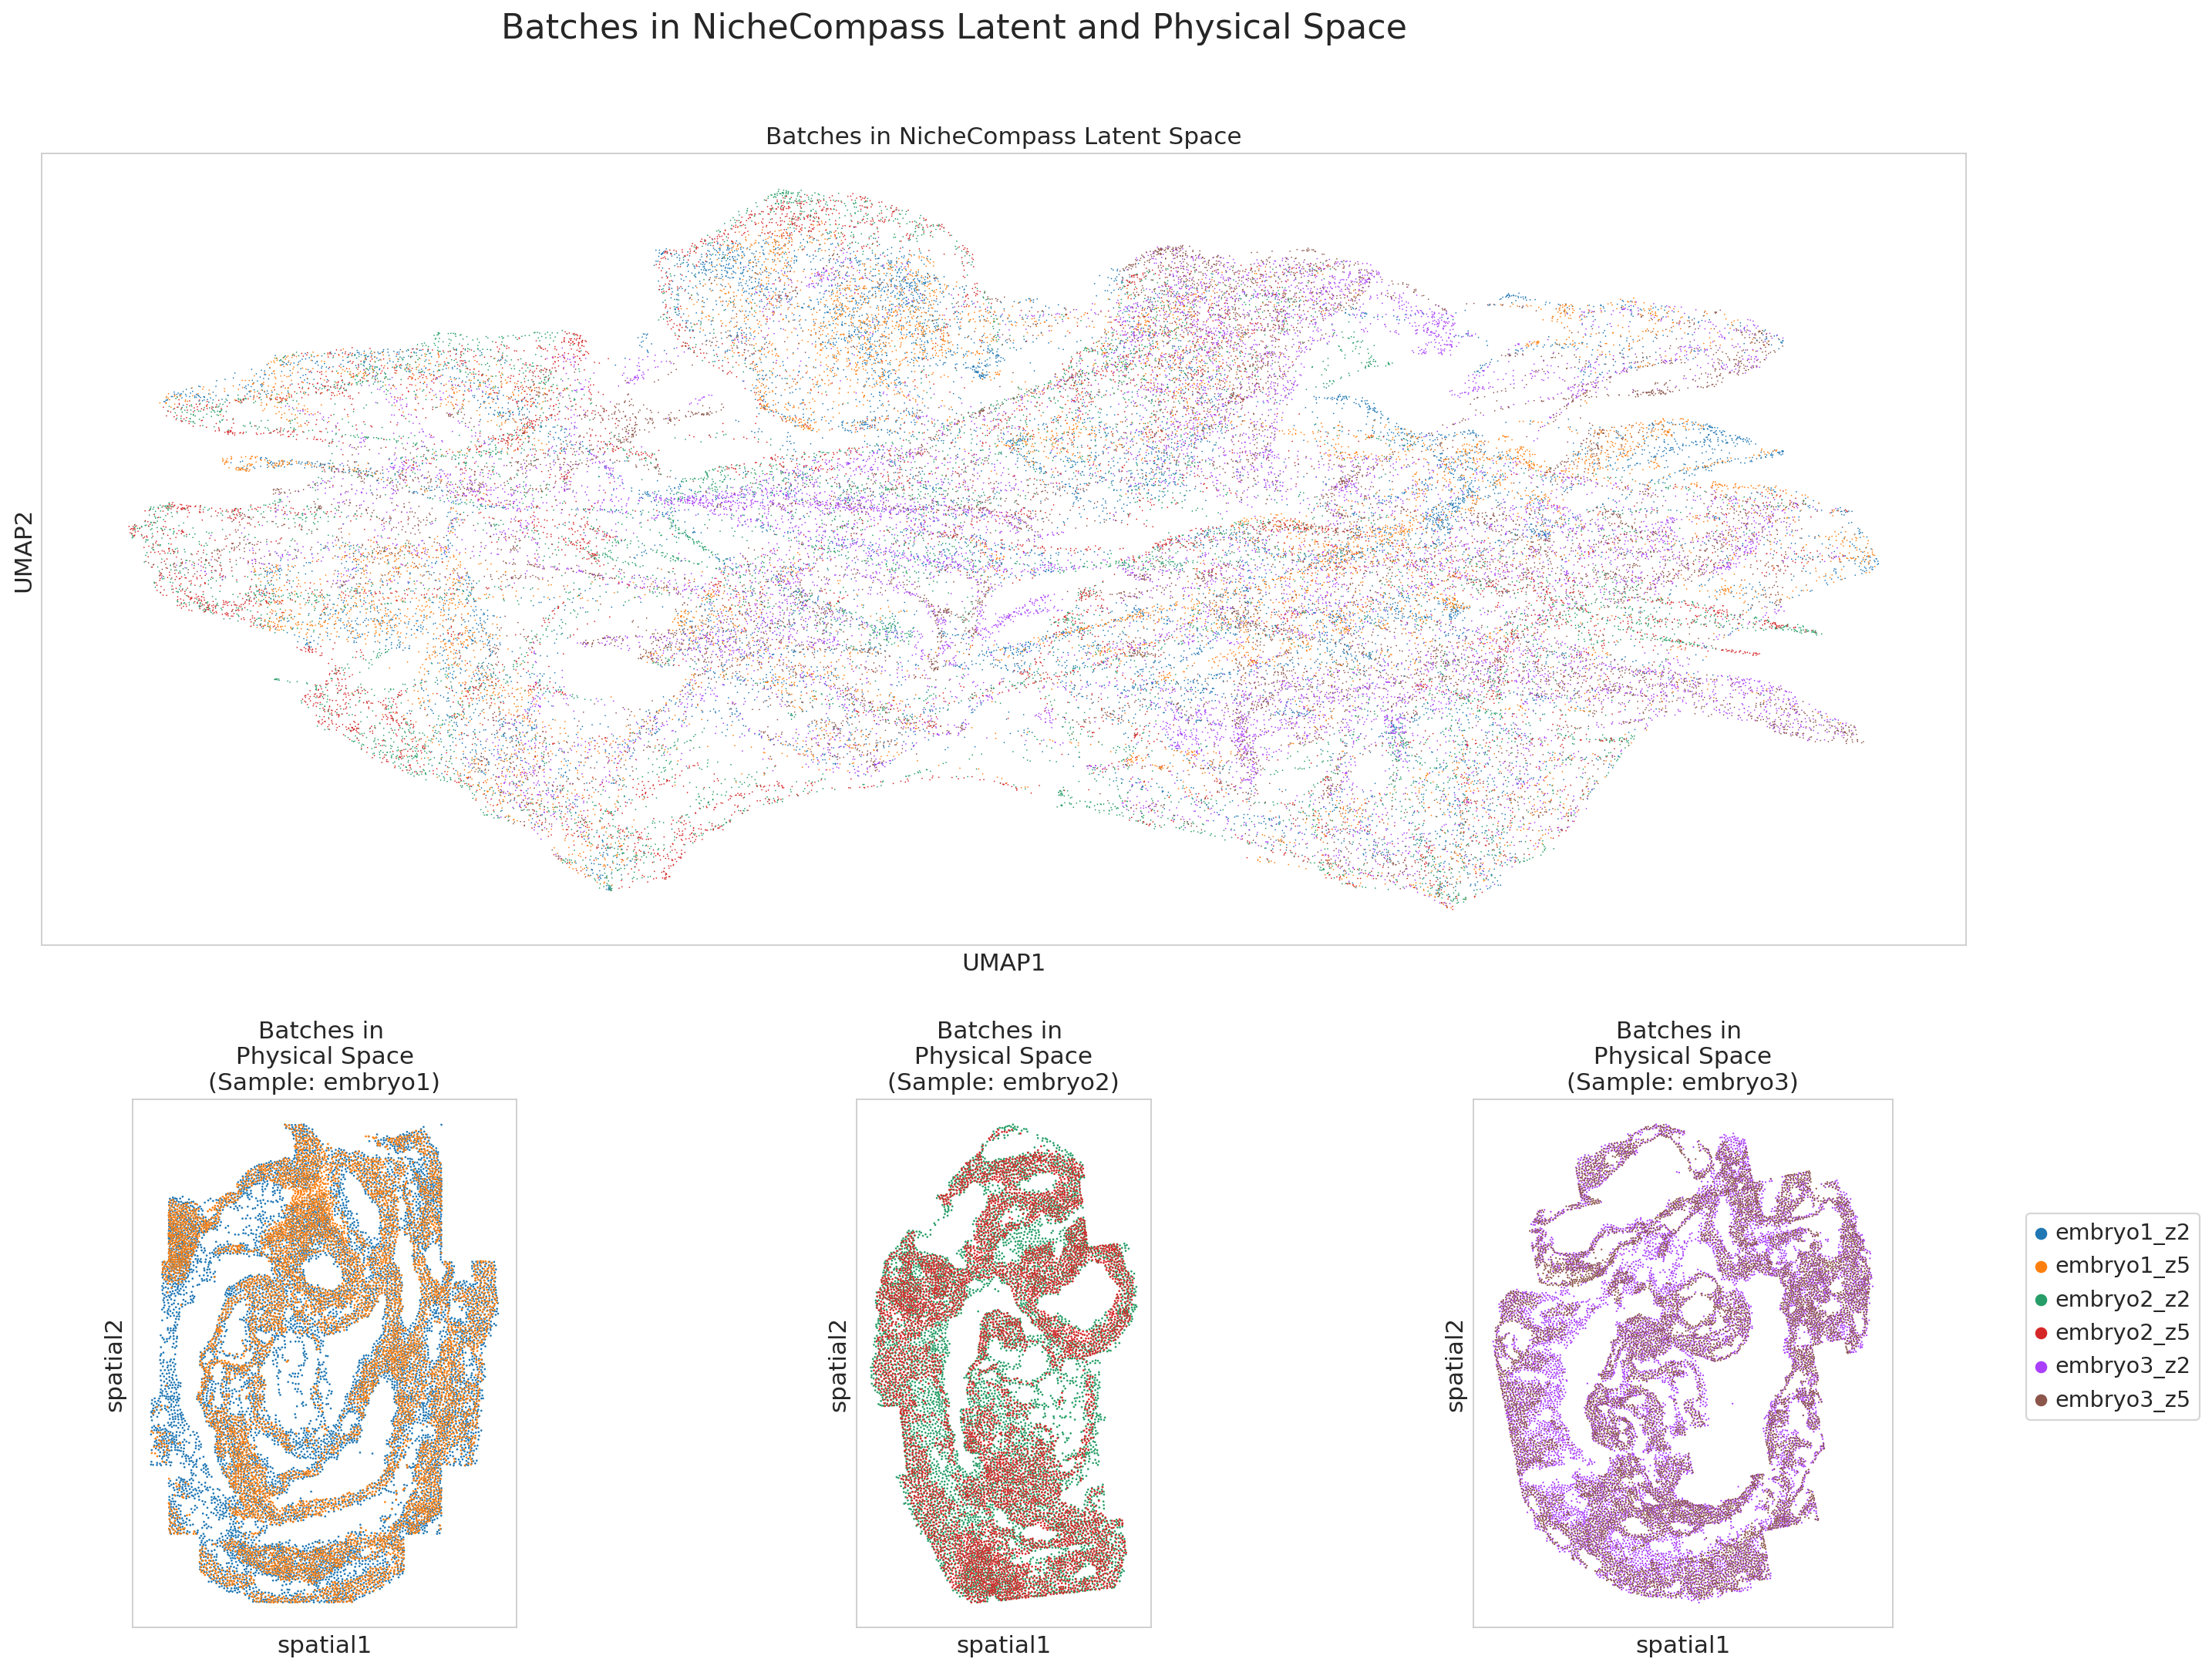

In [21]:
# Plot batches in latent and physical space
save_fig = True
file_path = f"{figure_folder_path}/" \
            "batches_latent_physical_space.svg"

plot_category_in_latent_and_physical_space(
    adata=model.adata,
    plot_label="Batches",
    cat_key=condition_key,
    groups=None,
    sample_key=sample_key,
    samples=samples,
    cat_colors=None,
    size=None,
    spot_size=spot_size,
    save_fig=save_fig,
    file_path=file_path)

In [22]:
cell_type_colors = create_new_color_dict(
    adata=model.adata,
    cat_key=cell_type_key)

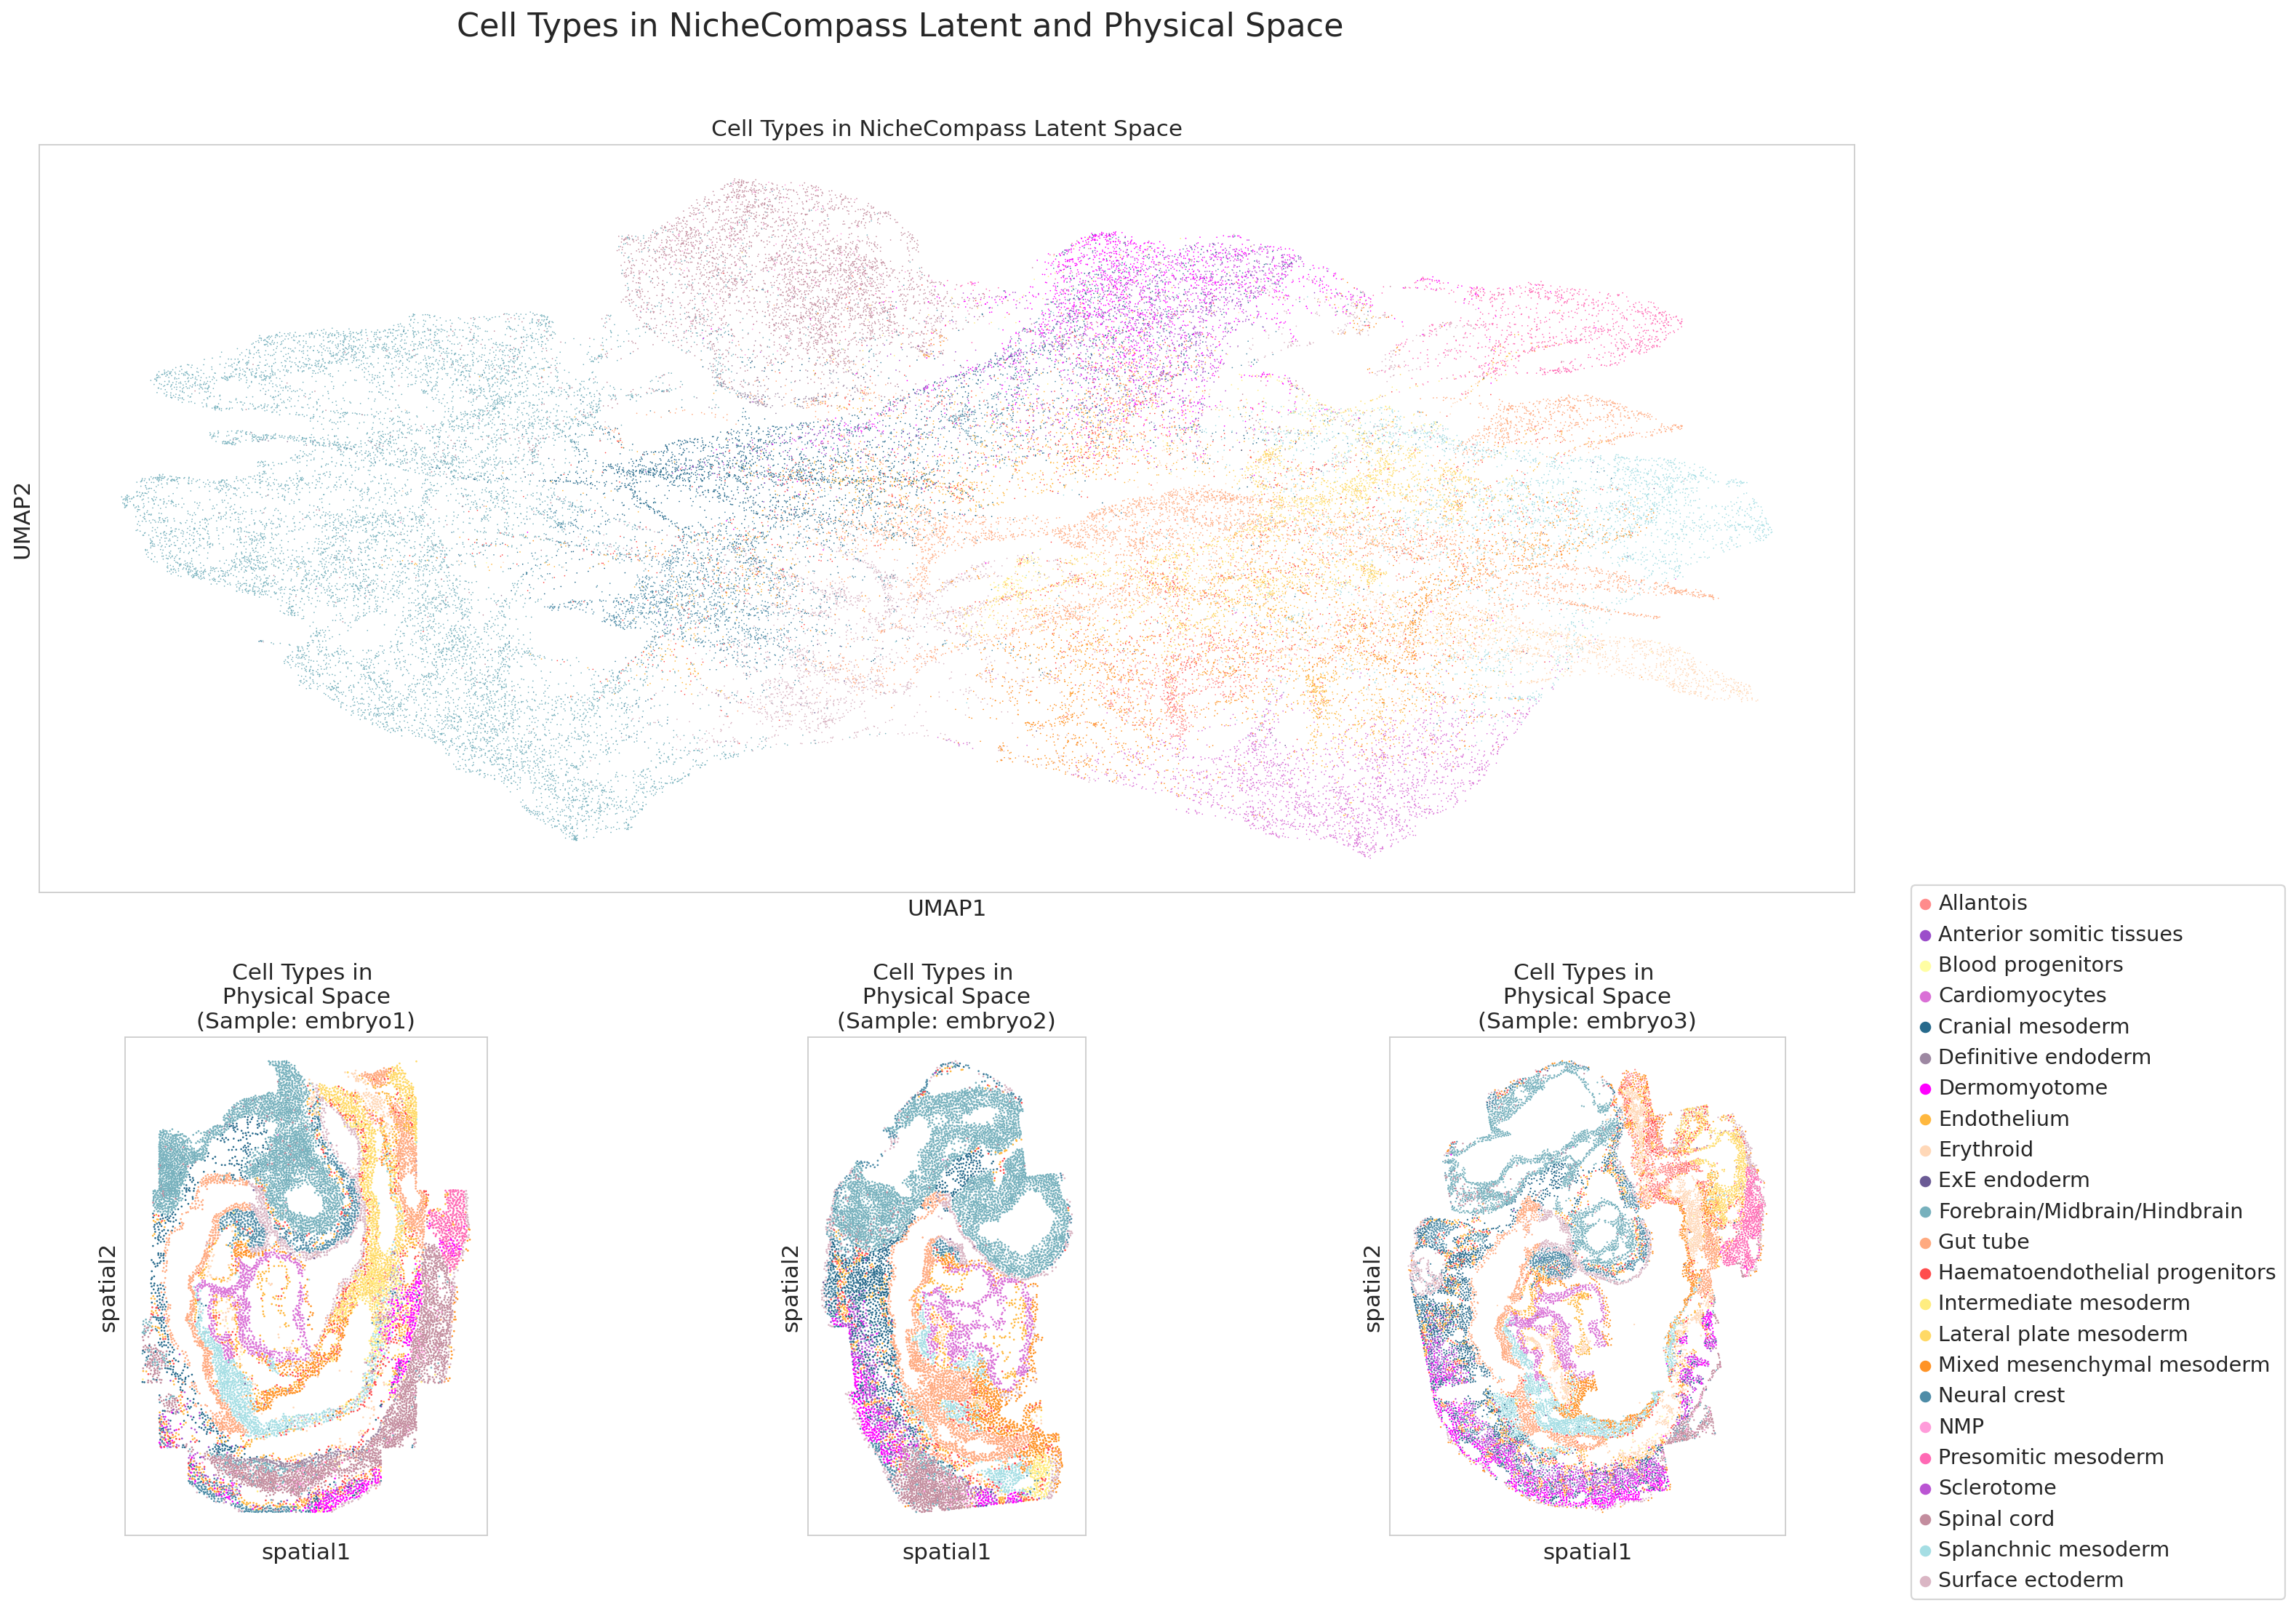

In [23]:
# Plot cell types in latent and physical space
save_fig = True
file_path = f"{figure_folder_path}/" \
            "cell_types_latent_physical_space.svg"

plot_category_in_latent_and_physical_space(
    adata=model.adata,
    plot_label="Cell Types",
    cat_key=cell_type_key,
    groups=None,
    sample_key=sample_key,
    samples=samples,
    cat_colors=cell_type_colors,
    size=None,
    spot_size=spot_size,
    save_fig=save_fig,
    file_path=file_path)

In [24]:
if len(cell_type_groups) > 0:
    # Plot cell type groups in latent and physical space
    save_fig = True
    file_path = f"{figure_folder_path}/{'_'.join(cell_type_groups).lower()}" \
                "_latent_physical_space.svg"

    plot_category_in_latent_and_physical_space(
        adata=model.adata,
        plot_label=f"{'_'.join(cell_type_groups)}",
        cat_key=cell_type_key,
        groups=cell_type_groups,
        sample_key=sample_key,
        samples=samples,
        cat_colors=cell_type_colors,
        size=None,
        spot_size=spot_size,
        save_fig=save_fig,
        file_path=file_path)

In [25]:
latent_leiden_resolution = 0.03

In [26]:
# Compute latent Leiden clustering
sc.tl.leiden(adata=model.adata,
             resolution=latent_leiden_resolution,
             key_added=latent_cluster_key,
             neighbors_key=latent_key)

In [27]:
latent_cluster_colors = create_new_color_dict(
    adata=model.adata,
    cat_key=latent_cluster_key)

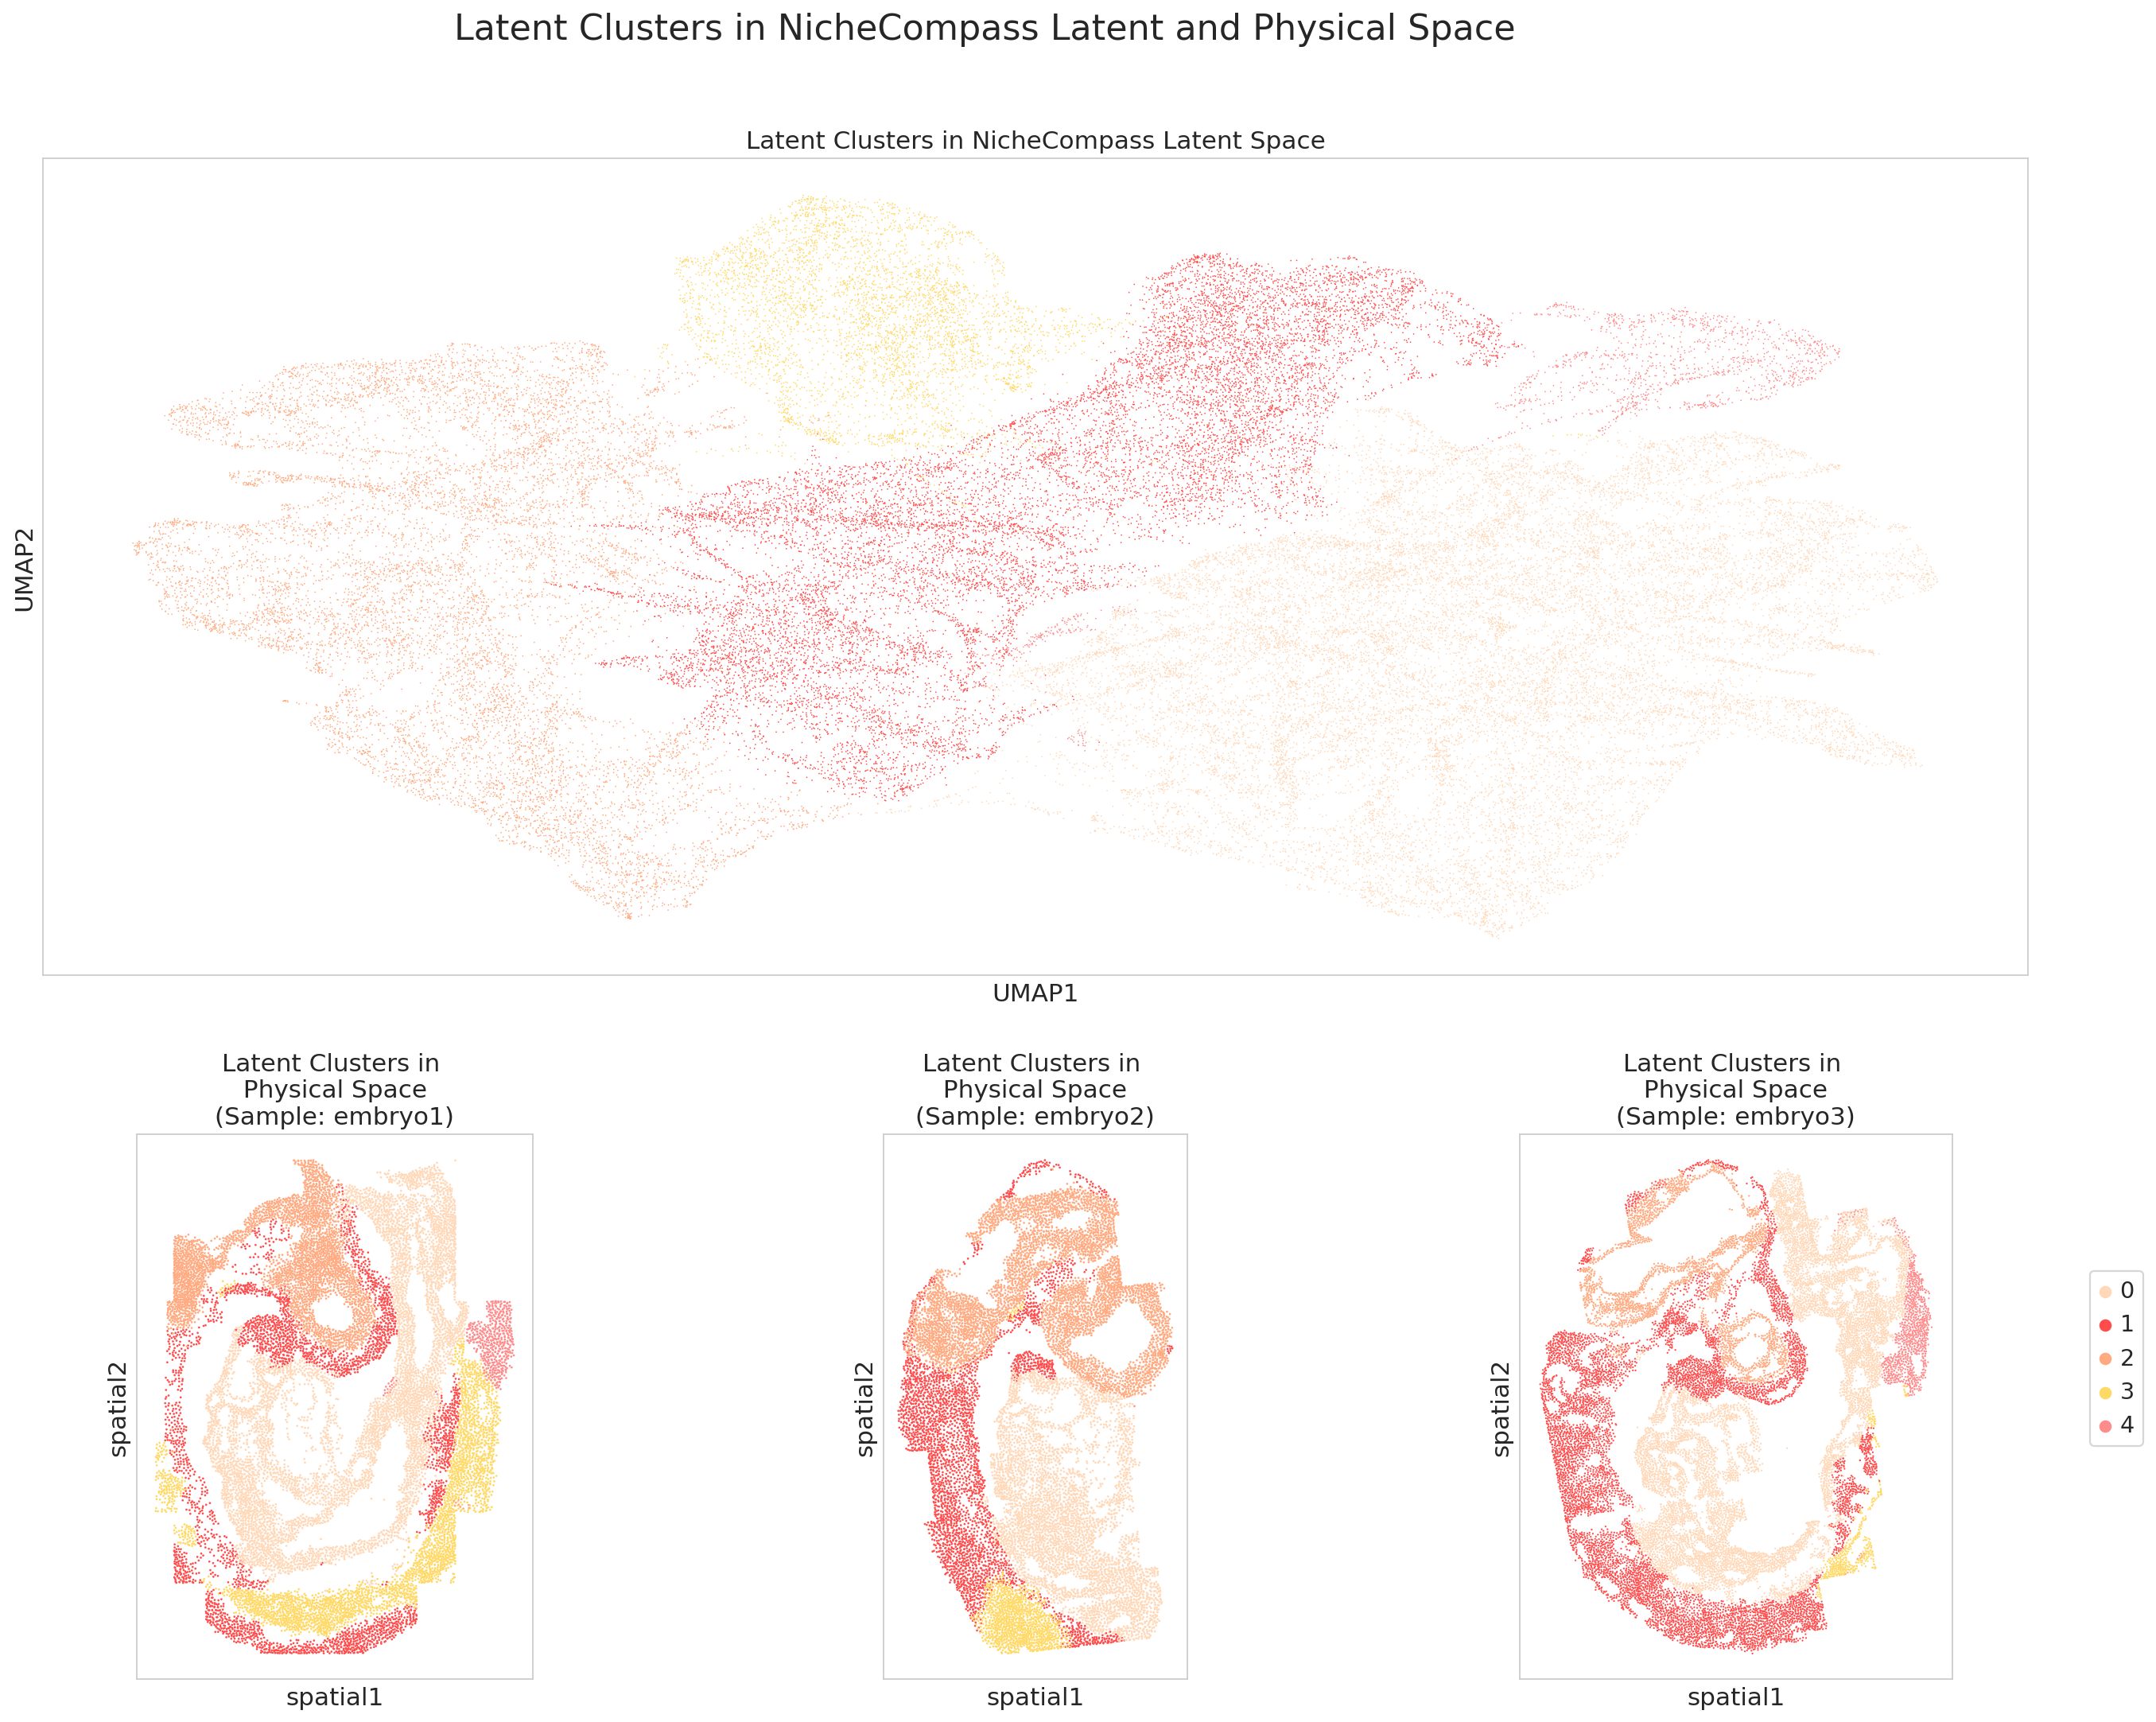

In [28]:
# Latent clusters in latent and physical space
save_fig = True
file_path = f"{figure_folder_path}/res_{latent_leiden_resolution}_" \
            "latent_clusters_latent_physical_space.svg"

plot_category_in_latent_and_physical_space(
    adata=model.adata,
    plot_label="Latent Clusters",
    cat_key=latent_cluster_key,
    groups=None,
    sample_key=sample_key,
    samples=samples,
    cat_colors=latent_cluster_colors,
    size=None,
    spot_size=spot_size,
    save_fig=save_fig,
    file_path=file_path)

In [ ]:
adata = sc.read_h5ad("../artifacts/xenium_human_breast_cancer/results/one-hop-norm_reference/20062023_165327_6/xenium_human_breast_cancer_analysis.h5ad")

In [ ]:
adata = sc.read_h5ad("../artifacts/seqfish_mouse_organogenesis_embryo2/models/one-hop-attention_single_sample_method_benchmarking/21062023_125840/run2/seqfish_mouse_organogenesis_embryo2_one-hop-attention_single_sample_method_benchmarking.h5ad")

In [ ]:
adata

In [ ]:
adata2 = sc.read_h5ad("../artifacts/seqfish_mouse_organogenesis_embryo2/results/one-hop-attention_single_sample_method_benchmarking/21062023_125840/seqfish_mouse_organogenesis_embryo2_one-hop-attention_single_sample_method_benchmarking.h5ad")

In [ ]:
adata2

In [ ]:
adata3 = sc.read_h5ad("../artifacts/seqfish_mouse_organogenesis_embryo2/models/one-hop-attention_single_sample_method_benchmarking/21062023_125840/run1/seqfish_mouse_organogenesis_embryo2_one-hop-attention_single_sample_method_benchmarking.h5ad")

In [ ]:
adata3.uns["nichecompass_targets_categories_label_encoder"]

In [ ]:
for latent_cluster in model.adata.obs[latent_cluster_key].unique().tolist():
    # Latent clusters in latent and physical space
    save_fig = True
    file_path = f"{figure_folder_path}/res_{latent_leiden_resolution}_" \
                f"latent_cluster_{latent_cluster}_latent_physical_space.svg"

    plot_category_in_latent_and_physical_space(
        adata=model.adata,
        plot_label="Latent Clusters",
        cat_key=latent_cluster_key,
        groups=latent_cluster,
        sample_key=sample_key,
        samples=samples,
        cat_colors=latent_cluster_colors,
        size=None,
        spot_size=spot_size,
        save_fig=save_fig,
        file_path=file_path)

In [ ]:
if len(latent_groups) > 0:
    # Plot latent cluster groups in latent and physical space
    save_fig = True
    file_path = f"{figure_folder_path}/{'_'.join(latent_groups).lower()}" \
                "_latent_physical_space.svg"

    plot_category_in_latent_and_physical_space(
        adata=model.adata,
        plot_label=f"{'_'.join(latent_groups)}",
        cat_key=latent_cluster_key,
        groups=latent_groups,
        sample_key=sample_key,
        samples=samples,
        cat_colors=latent_cluster_colors,
        size=None,
        spot_size=spot_size,
        save_fig=save_fig,
        file_path=file_path)

In [ ]:
if dataset == "spatial_atac_rna_seq_mouse_brain_batch2":
    save_fig = True
    file_path = f"{figure_folder_path}/" \
                "rna_cluster_annotations_latent_physical_space.svg"

    plot_category_in_latent_and_physical_space(
        adata=model.adata,
        plot_label="RNA Clusters",
        cat_key=rna_cluster_key,
        groups=None,
        sample_key=sample_key,
        samples=samples,
        cat_colors=rna_cluster_colors,
        size=None,
        spot_size=spot_size,
        save_fig=save_fig,
        file_path=file_path)

    save_fig = True
    file_path = f"{figure_folder_path}/" \
                "atac_cluster_annotations_latent_physical_space.svg"

    plot_category_in_latent_and_physical_space(
        adata=model.adata,
        plot_label="ATAC Clusters",
        cat_key=atac_cluster_key,
        groups=None,
        sample_key=sample_key,
        samples=samples,
        cat_colors=atac_cluster_colors,
        size=None,
        spot_size=spot_size,
        save_fig=save_fig,
        file_path=file_path)

### 3.2 Analyze GPs & GP Genes

In [ ]:
# Get gp scores of all gps (active & inactive)
latent, _ = model.get_latent_representation(
    adata=model.adata,
    counts_key=counts_key,
    adj_key=adj_key,
    condition_key=condition_key,
    only_active_gps=False,
    return_mu_std=True,
    node_batch_size=model.node_batch_size_)

# Store gp scores, spatial coords and spatial neighbor graph in new adata
gp_adata = ad.AnnData(latent)
gp_adata.obs_names = model.adata.obs_names
gp_adata.var_names = model.adata.uns[gp_names_key]
gp_adata.obs[condition_key] = model.adata.obs[condition_key]
gp_adata.obsp[adj_key] = model.adata.obsp[adj_key]
gp_adata.obsm[spatial_key] = model.adata.obsm[spatial_key]

In [ ]:
# Compute spatial autocorrelation score Moran I of gene programs
# (higher score -> positive spatial autocorrelation)
sq.gr.spatial_autocorr(gp_adata,
                       mode="moran",
                       n_perms=100,
                       n_jobs=1)

# Add score to summary df
gp_summary_df["gp_moranI"] = gp_adata.uns["moranI"].loc[
    gp_summary_df["gp_name"].values.tolist(), "I"].values

In [ ]:
# Plot gp with highest moran I score
sq.pl.spatial_scatter(
    gp_adata[gp_adata.obs[condition_key] == samples[0]],
    shape=None,
    color=[gp_summary_df[["gp_name", "gp_moranI"]].sort_values(by="gp_moranI", ascending=False).head(1)["gp_name"].values[0]],
    size=0.1)

In [ ]:
# Plot gp with lowest moran I score
sq.pl.spatial_scatter(
    gp_adata[gp_adata.obs[condition_key] == samples[0]],
    shape=None,
    color=[gp_summary_df[["gp_name", "gp_moranI"]].sort_values(by="gp_moranI", ascending=False).tail(1)["gp_name"].values[0]],
    size=0.1)

In [ ]:
# Determine highly variable gene programs
hvgp_threshs = [0.1]

hvgp_list = []
hvgp_cols = []
for hvgp_thresh in hvgp_threshs:

    sc.pp.highly_variable_genes(
        gp_adata,
        n_top_genes=int(len(gp_adata.var) * hvgp_thresh),
        flavor="seurat",
        # batch_key=condition_key,
        subset=False)

    hvgp_list.append(gp_adata[:, gp_adata.var["highly_variable"]].var_names.tolist())
    
for i, hvgp_thresh in enumerate(hvgp_threshs):
    gp_summary_df[f"hvgp_{hvgp_thresh}_thresh"] = gp_summary_df["gp_name"].isin(hvgp_list[i])
    hvgp_cols.append(f"hvgp_{hvgp_thresh}_thresh")
    
gp_summary_df.loc[:, "gp_category"] = "inactive"
gp_summary_df.loc[
    gp_summary_df["gp_name"].isin(active_gps), "gp_category"] = "active"
gp_summary_df.loc[
    gp_summary_df["gp_name"].isin(hvgp_list[0]), "gp_category"] = "highly_variable"

In [ ]:
# Retrieve genes, gene importances, gene ranks, and mean gene expr of target and source genes respectively
gp_target_genes_df = gp_summary_df[
    ["gp_name",
     "gp_active",
     "gp_category",
     "gp_moranI",
     "gp_target_genes",
     "gp_target_genes_importances"] +
     hvgp_cols].explode(
        ["gp_target_genes",
         "gp_target_genes_importances"]).rename(
            columns={"gp_target_genes": "target_gene",
                     "gp_target_genes_importances": "target_gene_importance"}).dropna()
gp_target_genes_df["target_gene_rank"] = gp_target_genes_df.groupby("gp_name").cumcount() + 1
gp_target_genes_df["target_gene_importance"] = gp_target_genes_df["target_gene_importance"].astype(np.float32)
gp_target_genes_df["target_gene_mean_log_norm_gene_expr"] = np.array(
    model.adata[:, gp_target_genes_df["target_gene"]].layers[counts_key].mean(0)).flatten()

gp_source_genes_df = gp_summary_df[
    ["gp_name",
     "gp_active",
     "gp_category",
     "gp_moranI",
     "gp_source_genes",
     "gp_source_genes_importances"] +
     hvgp_cols].explode(
        ["gp_source_genes",
         "gp_source_genes_importances"]).rename(
            columns={"gp_source_genes": "source_gene",
                     "gp_source_genes_importances": "source_gene_importance"}).dropna()
gp_source_genes_df["source_gene_rank"] = gp_source_genes_df.groupby("gp_name").cumcount() + 1
gp_source_genes_df["source_gene_importance"] = gp_source_genes_df["source_gene_importance"].astype(np.float32)
gp_source_genes_df["source_gene_mean_log_norm_gene_expr"] = np.array(
    model.adata[:, gp_source_genes_df["source_gene"]].layers[counts_key].mean(0)).flatten()

In [ ]:
# Compute spatial autocorrelation score Moran I of genes
# (higher score -> positive spatial autocorrelation)
genes = list(set(list(gp_target_genes_df["target_gene"]) + list(gp_source_genes_df["source_gene"])))

sq.gr.spatial_autocorr(model.adata,
                       mode="moran",
                       genes=genes,
                       n_perms=100,
                       n_jobs=1)

target_genes_moranI_scores = []
for gene in gp_target_genes_df["target_gene"]:
    target_genes_moranI_scores.append(
        model.adata.uns["moranI"].loc[gene, "I"])
gp_target_genes_df["gene_moranI"] = target_genes_moranI_scores

source_genes_moranI_scores = []
for gene in gp_source_genes_df["source_gene"]:
    source_genes_moranI_scores.append(
        model.adata.uns["moranI"].loc[gene, "I"])
gp_source_genes_df["gene_moranI"] = source_genes_moranI_scores

In [ ]:
# Create summary plots over all gps, active gps, and inactive gps 
# with fixed n_top_genes
n_top_genes = 3
use_only_active_gps = False
    
gp_target_genes_df_top_genes = gp_target_genes_df[
    gp_target_genes_df["target_gene_rank"] <= n_top_genes]
gp_source_genes_df_top_genes = gp_source_genes_df[
    gp_source_genes_df["source_gene_rank"] <= n_top_genes]

all_gp_target_genes_df_top_genes = gp_target_genes_df_top_genes
active_gp_target_genes_df_top_genes = gp_target_genes_df_top_genes[
    gp_target_genes_df_top_genes["gp_active"]]
inactive_gp_target_genes_df_top_genes = gp_target_genes_df_top_genes[
    ~gp_target_genes_df_top_genes["gp_active"]]

all_gp_source_genes_df_top_genes = gp_source_genes_df_top_genes
active_gp_source_genes_df_top_genes = gp_source_genes_df_top_genes[
    gp_source_genes_df_top_genes["gp_active"]]
inactive_gp_source_genes_df_top_genes = gp_source_genes_df_top_genes[
    ~gp_source_genes_df_top_genes["gp_active"]]

# Plot distribution of gene importances
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 15))
axs = axs.flatten()
plt.suptitle("Gene Importance Distributions")
sns.histplot(all_gp_target_genes_df_top_genes["target_gene_importance"],
             ax=axs[0],
             bins=20)
axs[0].set(title="Target Genes (All GPs)",
           xlabel="Gene Importance",
           ylabel="Target Gene Count")
sns.histplot(all_gp_source_genes_df_top_genes["source_gene_importance"],
             ax=axs[1],
             bins=20)
axs[1].set(title="Source Genes (All GPs)",
           xlabel="Gene Importance",
           ylabel="Source Gene Count")
sns.histplot(active_gp_target_genes_df_top_genes["target_gene_importance"],
             ax=axs[2],
             bins=20)
axs[2].set(title="Target Genes (Active GPs)",
           xlabel="Gene Importance",
           ylabel="Target Gene Count")
sns.histplot(active_gp_source_genes_df_top_genes["source_gene_importance"],
             ax=axs[3],
             bins=20)
axs[3].set(title="Source Genes (Active GPs)",
           xlabel="Gene Importance",
           ylabel="Source Gene Count")
sns.histplot(inactive_gp_target_genes_df_top_genes["target_gene_importance"],
             ax=axs[4],
             bins=20)
axs[4].set(title="Target Genes (Inactive GPs)",
           xlabel="Gene Importance",
           ylabel="Target Gene Count")
sns.histplot(inactive_gp_source_genes_df_top_genes["source_gene_importance"],
             ax=axs[5],
             bins=20)
axs[5].set(title="Source Genes (Inactive GPs)",
           xlabel="Gene Importance",
           ylabel="Source Gene Count")
plt.subplots_adjust(wspace=0.35, hspace=0.3)
plt.show()

# Plot relationship between gene importances and log-normalized gene expression
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(20, 15))
axs = axs.flatten()
plt.suptitle("Relationship between NicheCompass Gene Importances "
             "and Mean Log-Normalized Gene Expression of Genes")
sns.regplot(x=all_gp_target_genes_df_top_genes["target_gene_importance"],
            y=all_gp_target_genes_df_top_genes["target_gene_mean_log_norm_gene_expr"],
            ax=axs[0])
_, _, r_value, p_value, _ = stats.linregress(
    x=all_gp_target_genes_df_top_genes["target_gene_importance"],
    y=all_gp_target_genes_df_top_genes["target_gene_mean_log_norm_gene_expr"])
all_gp_target_genes_r_squared = r_value ** 2
axs[0].set_title(f"Target Genes (All GPs) - R2: {round(all_gp_target_genes_r_squared, 4)}; "
                 f"P: {round(p_value, 4)}",
                 fontsize=14)
axs[0].set(xlabel="Gene Importance",
           ylabel="Mean Log-Normalized Gene Expr")
sns.regplot(x=all_gp_source_genes_df_top_genes["source_gene_importance"],
            y=all_gp_source_genes_df_top_genes["source_gene_mean_log_norm_gene_expr"],
            ax=axs[1])
_, _, r_value, p_value, _ = stats.linregress(
    x=all_gp_source_genes_df_top_genes["source_gene_importance"],
    y=all_gp_source_genes_df_top_genes["source_gene_mean_log_norm_gene_expr"])
all_gp_source_genes_r_squared = r_value ** 2
axs[1].set_title(f"Source Genes (All GPs) - R2: {round(all_gp_source_genes_r_squared, 4)}; "
                 f"P: {round(p_value, 4)}",
                 fontsize=14)
axs[1].set(xlabel="Gene Importance",
           ylabel="Mean Log-Normalized Gene Expr")
sns.regplot(x=active_gp_target_genes_df_top_genes["target_gene_importance"],
            y=active_gp_target_genes_df_top_genes["target_gene_mean_log_norm_gene_expr"],
            ax=axs[2])
_, _, r_value, p_value, _ = stats.linregress(
    x=active_gp_target_genes_df_top_genes["target_gene_importance"],
    y=active_gp_target_genes_df_top_genes["target_gene_mean_log_norm_gene_expr"])
active_gp_target_genes_r_squared = r_value ** 2
axs[2].set_title(f"Target Genes (Active GPs) - R2: {round(active_gp_target_genes_r_squared, 4)};  "
                 f"P: {round(p_value, 4)}",
                 fontsize=14)
axs[2].set(xlabel="Gene Importance",
           ylabel="Mean Log-Normalized Gene Expr")
sns.regplot(x=active_gp_source_genes_df_top_genes["source_gene_importance"],
            y=active_gp_source_genes_df_top_genes["source_gene_mean_log_norm_gene_expr"],
            ax=axs[3])
_, _, r_value, p_value, _ = stats.linregress(
    x=active_gp_source_genes_df_top_genes["source_gene_importance"],
    y=active_gp_source_genes_df_top_genes["source_gene_mean_log_norm_gene_expr"])
active_gp_source_genes_r_squared = r_value ** 2
axs[3].set_title(f"Source Genes (Active GPs) - R2: {round(active_gp_source_genes_r_squared, 4)}; "
                 f"P: {round(p_value, 4)}",
                 fontsize=14)
axs[3].set(xlabel="Gene Importance",
           ylabel="Mean Log-Normalized Gene Expr")
if len(active_gps) != len(gp_summary_df):
    sns.regplot(x=inactive_gp_target_genes_df_top_genes["target_gene_importance"],
                y=inactive_gp_target_genes_df_top_genes["target_gene_mean_log_norm_gene_expr"],
                ax=axs[4])
    _, _, r_value, p_value, _ = stats.linregress(
        x=inactive_gp_target_genes_df_top_genes["target_gene_importance"],
        y=inactive_gp_target_genes_df_top_genes["target_gene_mean_log_norm_gene_expr"])
    inactive_gp_target_genes_r_squared = r_value ** 2
    axs[4].set_title(f"Target Genes (Inactive GPs) - R2: {round(inactive_gp_target_genes_r_squared, 4)}; "
                     f"P: {round(p_value, 4)}",
                     fontsize=14)
    axs[4].set(xlabel="Gene Importance",
               ylabel="Mean Log-Normalized Gene Expr")
    sns.regplot(x=inactive_gp_source_genes_df_top_genes["source_gene_importance"],
                y=inactive_gp_source_genes_df_top_genes["source_gene_mean_log_norm_gene_expr"],
                ax=axs[5])
    _, _, r_value, p_value, _ = stats.linregress(
        x=inactive_gp_source_genes_df_top_genes["source_gene_importance"],
        y=inactive_gp_source_genes_df_top_genes["source_gene_mean_log_norm_gene_expr"])
    inactive_gp_source_genes_r_squared = r_value ** 2
    axs[5].set_title(f"Source Genes (Inactive GPs) - R2: {round(inactive_gp_source_genes_r_squared, 4)}; "
                     f"P: {round(p_value, 4)}",
                     fontsize=14)
    axs[5].set(xlabel="Gene Importance",
               ylabel="Mean Log-Normalized Gene Expr")
plt.subplots_adjust(wspace=0.35, hspace=0.3)
plt.show()

# Plot relationship between gene importances and Moran's I score
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(20, 15))
axs = axs.flatten()
plt.suptitle("Relationship between NicheCompass Gene Importances "
             "and Moran's I Scores of Genes")
sns.regplot(x=all_gp_target_genes_df_top_genes["target_gene_importance"],
            y=all_gp_target_genes_df_top_genes["gene_moranI"],
            ax=axs[0])
_, _, r_value, p_value, _ = stats.linregress(
    x=all_gp_target_genes_df_top_genes.dropna()["target_gene_importance"],
    y=all_gp_target_genes_df_top_genes.dropna()["gene_moranI"])
all_gp_target_genes_r_squared = r_value ** 2
axs[0].set_title(f"Target Genes (All GPs) - R2: {round(all_gp_target_genes_r_squared, 4)}; "
                 f"P: {round(p_value, 4)}",
                 fontsize=14)
axs[0].set(xlabel="Gene Importance",
           ylabel="Moran's I Score")
sns.regplot(x=all_gp_source_genes_df_top_genes["source_gene_importance"],
            y=all_gp_source_genes_df_top_genes["gene_moranI"],
            ax=axs[1])
_, _, r_value, p_value, _ = stats.linregress(
    x=all_gp_source_genes_df_top_genes.dropna()["source_gene_importance"],
    y=all_gp_source_genes_df_top_genes.dropna()["gene_moranI"])
all_gp_source_genes_r_squared = r_value ** 2
axs[1].set_title(f"Source Genes (All GPs) - R2: {round(all_gp_source_genes_r_squared, 4)}; "
                 f"P: {round(p_value, 4)}",
                 fontsize=14)
axs[1].set(xlabel="Gene Importance",
           ylabel="Moran's I Score")
sns.regplot(x=active_gp_target_genes_df_top_genes["target_gene_importance"],
            y=active_gp_target_genes_df_top_genes["gene_moranI"],
            ax=axs[2])
_, _, r_value, p_value, _ = stats.linregress(
    x=active_gp_target_genes_df_top_genes.dropna()["target_gene_importance"],
    y=active_gp_target_genes_df_top_genes.dropna()["gene_moranI"])
active_gp_target_genes_r_squared = r_value ** 2
axs[2].set_title(f"Target Genes (Active GPs) - R2: {round(active_gp_target_genes_r_squared, 4)}; "
                 f"P: {round(p_value, 4)}",
                 fontsize=14)
axs[2].set(xlabel="Gene Importance",
           ylabel="Moran's I Score")
sns.regplot(x=active_gp_source_genes_df_top_genes["source_gene_importance"],
            y=active_gp_source_genes_df_top_genes["gene_moranI"],
            ax=axs[3])
_, _, r_value, p_value, _ = stats.linregress(
    x=active_gp_source_genes_df_top_genes.dropna()["source_gene_importance"],
    y=active_gp_source_genes_df_top_genes.dropna()["gene_moranI"])
active_gp_source_genes_r_squared = r_value ** 2
axs[3].set_title(f"Source Genes (Active GPs) - R2: {round(active_gp_source_genes_r_squared, 4)}; "
                 f"P: {round(p_value, 4)}",
                 fontsize=14)
axs[3].set(xlabel="Gene Importance",
           ylabel="Moran's I Score")
if len(active_gps) != len(gp_summary_df):
    sns.regplot(x=inactive_gp_target_genes_df_top_genes["target_gene_importance"],
                y=inactive_gp_target_genes_df_top_genes["gene_moranI"],
                ax=axs[4])
    _, _, r_value, p_value, _ = stats.linregress(
        x=inactive_gp_target_genes_df_top_genes.dropna()["target_gene_importance"],
        y=inactive_gp_target_genes_df_top_genes.dropna()["gene_moranI"])
    inactive_gp_target_genes_r_squared = r_value ** 2
    axs[4].set_title(f"Target Genes (Inactive GPs) - R2: {round(inactive_gp_target_genes_r_squared, 4)}; "
                     f"P: {round(p_value, 4)}",
                     fontsize=14)
    axs[4].set(xlabel="Gene Importance",
               ylabel="Moran's I Score")
    sns.regplot(x=inactive_gp_source_genes_df_top_genes["source_gene_importance"],
                y=inactive_gp_source_genes_df_top_genes["gene_moranI"],
                ax=axs[5])
    _, _, r_value, p_value, _ = stats.linregress(
        x=inactive_gp_source_genes_df_top_genes.dropna()["source_gene_importance"],
        y=inactive_gp_source_genes_df_top_genes.dropna()["gene_moranI"])
    inactive_gp_source_genes_r_squared = r_value ** 2
    axs[5].set_title(f"Source Genes (Inactive GPs) - R2: {round(inactive_gp_source_genes_r_squared, 4)}; "
                     f"P: {round(p_value, 4)}",
                     fontsize=14)
    axs[5].set(xlabel="Gene Importance",
               ylabel="Moran's I Score")
plt.subplots_adjust(wspace=0.35, hspace=0.3)
plt.show()

In [ ]:
# Plot relationship between gp moran scores and importance weighted gene moran scores
gp_target_genes_moran_df = gp_target_genes_df.groupby("gp_name").apply(
    lambda x: pd.Series({"weighted_gene_moranI": (
        x["target_gene_importance"] * x["gene_moranI"]).sum()}))
gp_target_genes_moran_df.reset_index(inplace=True)
gp_target_genes_moran_df = pd.merge(gp_target_genes_moran_df,
                                    gp_summary_df[["gp_name", "gp_active", "gp_moranI"]],
                                    on="gp_name")

gp_source_genes_moran_df = gp_source_genes_df.groupby("gp_name").apply(
    lambda x: pd.Series({"weighted_gene_moranI": (
        x["source_gene_importance"] * x["gene_moranI"]).sum()}))
gp_source_genes_moran_df.reset_index(inplace=True)
gp_source_genes_moran_df = pd.merge(gp_source_genes_moran_df,
                                    gp_summary_df[["gp_name", "gp_active", "gp_moranI"]],
                                    on="gp_name")

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axs = axs.flatten()
plt.suptitle("Relationship between GP Moran's I Score and \n"
             "Importance Weighted Gene Moran's I Scores")
sns.scatterplot(data=gp_target_genes_moran_df,
                x=gp_target_genes_moran_df["gp_moranI"],
                y=gp_target_genes_moran_df["weighted_gene_moranI"],
                hue=gp_target_genes_moran_df["gp_active"],
                ax=axs[0])
axs[0].set(title="Target Genes",
           xlabel="GP Moran's I Score",
           ylabel="Weighted Gene Moran's I Score")
sns.scatterplot(data=gp_source_genes_moran_df,
                x=gp_source_genes_moran_df["gp_moranI"],
                y=gp_source_genes_moran_df["weighted_gene_moranI"],
                hue=gp_source_genes_moran_df["gp_active"],
                ax=axs[1])
axs[1].set(title="Source Genes",
           xlabel="GP Moran's I Score",
           ylabel="Weighted Gene Moran's I Score")
plt.subplots_adjust(wspace=0.35, top=0.8)
plt.show()

In [ ]:
# Plot relationship between gp moran scores and importance weighted gene moran scores
# across all gps, active gps, and inactive gps

all_gp_target_genes_moran_df = gp_target_genes_moran_df
active_gp_target_genes_moran_df = gp_target_genes_moran_df[
    gp_target_genes_moran_df["gp_active"]]
inactive_gp_target_genes_moran_df = gp_target_genes_moran_df[
    ~gp_target_genes_moran_df["gp_active"]]

all_gp_source_genes_moran_df = gp_source_genes_moran_df
active_gp_source_genes_moran_df = gp_source_genes_moran_df[
    gp_source_genes_moran_df["gp_active"]]
inactive_gp_source_genes_moran_df = gp_source_genes_moran_df[
    ~gp_source_genes_moran_df["gp_active"]]

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(20, 15))
axs = axs.flatten()
plt.suptitle("Relationship between GP Moran's I Score and \n"
             "Importance Weighted Gene Moran's I Scores")
sns.regplot(x=all_gp_target_genes_moran_df["gp_moranI"],
            y=all_gp_target_genes_moran_df["weighted_gene_moranI"],
            ax=axs[0])
_, _, r_value, p_value, _ = stats.linregress(
    x=all_gp_target_genes_moran_df.dropna()["gp_moranI"],
    y=all_gp_target_genes_moran_df.dropna()["weighted_gene_moranI"])
r_squared = r_value ** 2
axs[0].set_title(f"Target Genes (All GPs) - R2: {round(r_squared, 4)}; "
                 f"P: {round(p_value, 4)}",
                 fontsize=14)
axs[0].set(xlabel="GP Moran's I Score",
           ylabel="Weighted Gene Moran's I Score")
sns.regplot(x=all_gp_source_genes_moran_df["gp_moranI"],
            y=all_gp_source_genes_moran_df["weighted_gene_moranI"],
            ax=axs[1])
_, _, r_value, p_value, _ = stats.linregress(
    x=all_gp_source_genes_moran_df.dropna()["gp_moranI"],
    y=all_gp_source_genes_moran_df.dropna()["weighted_gene_moranI"])
r_squared = r_value ** 2
axs[1].set_title(f"Source Genes (All GPs) - R2: {round(r_squared, 4)}; "
                 f"P: {round(p_value, 4)}",
                 fontsize=14)
axs[1].set(xlabel="GP Moran's I Score",
           ylabel="Weighted Gene Moran's I Score")
sns.regplot(x=active_gp_target_genes_moran_df["gp_moranI"],
            y=active_gp_target_genes_moran_df["weighted_gene_moranI"],
            ax=axs[2])
_, _, r_value, p_value, _ = stats.linregress(
    x=active_gp_target_genes_moran_df.dropna()["gp_moranI"],
    y=active_gp_target_genes_moran_df.dropna()["weighted_gene_moranI"])
r_squared = r_value ** 2
axs[2].set_title(f"Target Genes (Active GPs) - R2: {round(r_squared, 4)}; "
                 f"P: {round(p_value, 4)}",
                 fontsize=14)
axs[2].set(xlabel="GP Moran's I Score",
           ylabel="Weighted Gene Moran's I Score")
sns.regplot(x=active_gp_source_genes_moran_df["gp_moranI"],
            y=active_gp_source_genes_moran_df["weighted_gene_moranI"],
            ax=axs[3])
_, _, r_value, p_value, _ = stats.linregress(
    x=active_gp_source_genes_moran_df.dropna()["gp_moranI"],
    y=active_gp_source_genes_moran_df.dropna()["weighted_gene_moranI"])
r_squared = r_value ** 2
axs[3].set_title(f"Source Genes (Active GPs) - R2: {round(r_squared, 4)}; "
                 f"P: {round(p_value, 4)}",
                 fontsize=14)
axs[3].set(xlabel="GP Moran's I Score",
           ylabel="Weighted Gene Moran's I Score")
if len(active_gps) != len(gp_summary_df):
    sns.regplot(x=inactive_gp_target_genes_moran_df["gp_moranI"],
                y=inactive_gp_target_genes_moran_df["weighted_gene_moranI"],
                ax=axs[4])
    _, _, r_value, p_value, _ = stats.linregress(
        x=inactive_gp_target_genes_moran_df.dropna()["gp_moranI"],
        y=inactive_gp_target_genes_moran_df.dropna()["weighted_gene_moranI"])
    r_squared = r_value ** 2
    axs[4].set_title(f"Target Genes (Inactive GPs) - R2: {round(r_squared, 4)}; "
                     f"P: {round(p_value, 4)}",
                     fontsize=14)
    axs[4].set(xlabel="GP Moran's I Score",
               ylabel="Weighted Gene Moran's I Score")
    sns.regplot(x=inactive_gp_source_genes_moran_df["gp_moranI"],
                y=inactive_gp_source_genes_moran_df["weighted_gene_moranI"],
                ax=axs[5])
    _, _, r_value, p_value, _ = stats.linregress(
        x=inactive_gp_source_genes_moran_df.dropna()["gp_moranI"],
        y=inactive_gp_source_genes_moran_df.dropna()["weighted_gene_moranI"])
    r_squared = r_value ** 2
    axs[5].set_title(f"Source Genes (Inactive GPs) - R2: {round(r_squared, 4)}; "
                     f"P: {round(p_value, 4)}",
                     fontsize=14)
    axs[5].set(xlabel="GP Moran's I Score",
               ylabel="Weighted Gene Moran's I Score")
plt.subplots_adjust(wspace=0.35, hspace=0.3)
plt.show()

In [ ]:
target_genes_weighted_moran_df = pd.DataFrame(columns=["GP Type", "GP Category", "Weighted Mean Moran's I Score"])
source_genes_weighted_moran_df = pd.DataFrame(columns=["GP Type", "GP Category", "Weighted Mean Moran's I Score"])

for gp_type, gp_type_identifier in zip(["OmniPath", "NicheNet", "MEBOCOST"],
                                       ["receptor", "target", "metabolite"]):
    gp_type_target_genes_df = gp_target_genes_df[gp_target_genes_df["gp_name"].str.contains(gp_type_identifier)]
    gp_type_source_genes_df = gp_source_genes_df[gp_source_genes_df["gp_name"].str.contains(gp_type_identifier)]

    target_genes_weighted_moran_sub_df = gp_type_target_genes_df.groupby("gp_category").apply(
        lambda x: pd.Series({"Weighted Mean Moran's I Score": (
            x["target_gene_importance"] * x["gene_moranI"]).sum() / x["target_gene_importance"].sum()}))

    #new_row = {"Weighted Mean Moran's I Score": gp_type_target_genes_df["moranI"].mean()}
    #index_label = "avg_across_all_gps"
    #new_df = pd.DataFrame(new_row, index=[index_label])
    #target_genes_weighted_moran_sub_df = pd.concat([target_genes_weighted_moran_sub_df,
    #                                              new_df])
    target_genes_weighted_moran_sub_df["GP Type"] = gp_type
    target_genes_weighted_moran_sub_df["GP Category"] = target_genes_weighted_moran_sub_df.index
    target_genes_weighted_moran_sub_df.reset_index(inplace=True)
    
    target_genes_weighted_moran_df = pd.concat([target_genes_weighted_moran_df,
                                                target_genes_weighted_moran_sub_df])

    source_genes_weighted_moran_sub_df = gp_type_source_genes_df.groupby("gp_category").apply(
        lambda x: pd.Series({"Weighted Mean Moran's I Score": (
            x["source_gene_importance"] * x["gene_moranI"]).sum() / x["source_gene_importance"].sum()}))

    #new_row = {"Weighted Mean Moran's I Score": gp_type_source_genes_df["moranI"].mean()}
    #index_label = "avg_across_all_gps"
    #new_df = pd.DataFrame(new_row, index=[index_label])
    #source_genes_weighted_moran_sub_df = pd.concat([source_genes_weighted_moran_sub_df,
    #                                              new_df])
    source_genes_weighted_moran_sub_df["GP Type"] = gp_type
    source_genes_weighted_moran_sub_df["GP Category"] = source_genes_weighted_moran_sub_df.index
    source_genes_weighted_moran_sub_df.reset_index(inplace=True)
    
    source_genes_weighted_moran_df = pd.concat([source_genes_weighted_moran_df,
                                                source_genes_weighted_moran_sub_df])
    
# Plot relationship between gene importances and Moran's I score
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
plt.suptitle("Mean Moran's I Score Weighted by NicheCompass Gene Importances ")
sns.stripplot(target_genes_weighted_moran_df,
              x="GP Type",
              y="Weighted Mean Moran's I Score",
              hue="GP Category",
              ax=ax1)
ax1.set_title("Target Genes",
              fontsize=14)
ax1.set(xlabel="GP Type",
        ylabel="Weighted Mean Moran's I Score")
handles, labels = ax1.get_legend_handles_labels()
lgd = fig.legend(handles,
                 labels,
                 loc="center left",
                 bbox_to_anchor=(0.98, 0.5))
ax1.get_legend().remove()
sns.stripplot(source_genes_weighted_moran_df,
              x="GP Type",
              y="Weighted Mean Moran's I Score",
              hue="GP Category",
              ax=ax2)
ax2.set_title("Source Genes",
              fontsize=14)
ax2.set(xlabel="GP Type",
        ylabel="Weighted Mean Moran's I Score")
ax2.get_legend().remove()
plt.subplots_adjust(wspace=0.35, top=0.85)
plt.show()

In [ ]:
# Create summary plots with variable n_top_genes
target_genes_corr_df = pd.DataFrame(columns=["Number of Top Genes", "GP Category", "Pearson Correlation"])
source_genes_corr_df = pd.DataFrame(columns=["Number of Top Genes", "GP Category", "Pearson Correlation"])

for n_top_genes in [5, 10, 20, 50, 100]:
    gp_target_genes_df_top_genes = gp_target_genes_df[gp_target_genes_df["target_gene_rank"] <= n_top_genes]
    gp_source_genes_df_top_genes = gp_source_genes_df[gp_source_genes_df["source_gene_rank"] <= n_top_genes]
    
    for gp_category in gp_target_genes_df_top_genes["gp_category"].unique().tolist():
        tmp_cat_df = gp_target_genes_df_top_genes.loc[gp_target_genes_df_top_genes["gp_category"] == gp_category]
        pearsonr = tmp_cat_df["target_gene_importance"].corr(tmp_cat_df["gene_moranI"])
        temp_row_dict = {"Number of Top Genes": n_top_genes,
                         "GP Category": gp_category,
                         "Pearson Correlation": pearsonr}
        target_genes_corr_df = target_genes_corr_df.append(temp_row_dict, ignore_index=True)
        
        tmp_cat_df = gp_source_genes_df_top_genes[gp_source_genes_df_top_genes["gp_category"] == gp_category]
        pearsonr = tmp_cat_df["source_gene_importance"].corr(tmp_cat_df["gene_moranI"])
        temp_row_dict = {"Number of Top Genes": n_top_genes,
                         "GP Category": gp_category,
                         "Pearson Correlation": pearsonr}
        source_genes_corr_df = source_genes_corr_df.append(temp_row_dict, ignore_index=True)
        
# Plot relationship between gene importances and Moran's I score
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
plt.suptitle("Pearson Correlation between NicheCompass Gene Importances "
             "and Moran's I Scores of Genes")
sns.stripplot(target_genes_corr_df,
              x="Number of Top Genes",
              y="Pearson Correlation",
              hue="GP Category",
              ax=ax1)
ax1.set_title("Target Genes",
              fontsize=14)
ax1.set(xlabel="Number of Top Genes",
        ylabel="Pearson Correlation")
handles, labels = ax1.get_legend_handles_labels()
lgd = fig.legend(handles,
                 labels,
                 loc="center left",
                 bbox_to_anchor=(0.98, 0.5))
ax1.get_legend().remove()
sns.stripplot(source_genes_corr_df,
              x="Number of Top Genes",
              y="Pearson Correlation",
              hue="GP Category",
              ax=ax2)
ax2.set_title("Source Genes",
              fontsize=14)
ax2.set(xlabel="Number of Top Genes",
        ylabel="Pearson Correlation")
ax2.get_legend().remove()
plt.subplots_adjust(wspace=0.35, top=0.85)
plt.show()

### 3.3 Latent Cluster Analysis

#### 3.3.1 One Cluster (All) vs Rest Differential GP Testing

In [ ]:
selected_cats = None
log_bayes_factor_thresh = 4.6 # 4.6 decisive threshold; 2.3 strong threshold (https://en.wikipedia.org/wiki/Bayes_factor)
title = f"NicheCompass Latent Cluster Enriched Gene Programs Log Bayes Factor {log_bayes_factor_thresh}"
save_fig = True
file_path = f"{figure_folder_path}/res_{latent_leiden_resolution}_" \
            f"latent_clusters_all_vs_rest_log_bayes_factor_" \
            f"{log_bayes_factor_thresh}_enriched_gps_dotplot.svg"

# Run differential gp testing
enriched_gps = model.run_differential_gp_tests(
    cat_key=latent_cluster_key,
    selected_cats=selected_cats,
    comparison_cats="rest",
    log_bayes_factor_thresh=log_bayes_factor_thresh)

fig = sc.pl.dotplot(model.adata,
                    enriched_gps,
                    groupby=latent_cluster_key,
                    dendrogram=True, 
                    title=title,
                    swap_axes=True,
                    return_fig=True,
                    figsize=(model.adata.obs[latent_cluster_key].nunique() / 2,
                             len(enriched_gps) / 2))
if save_fig:
    fig.savefig(file_path)
else:
    fig.show()

In [ ]:
save_file = True
file_path = f"{figure_folder_path}/res_{latent_leiden_resolution}_" \
            f"latent_clusters_all_vs_rest_log_bayes_factor_" \
            f"{log_bayes_factor_thresh}_enriched_gps_summary.csv"

gp_summary_cols = ["gp_name",
                   "n_source_genes",
                   "n_non_zero_source_genes",
                   "n_target_genes",
                   "n_non_zero_target_genes",
                   "gp_source_genes",
                   "gp_target_genes",
                   "gp_source_genes_weights_sign_corrected",
                   "gp_target_genes_weights_sign_corrected",
                   "gp_source_genes_importances",
                   "gp_target_genes_importances"]
if multimodal:
    gp_summary_cols = gp_summary_cols + [
        "n_source_peaks",
        "n_target_peaks",
        "gp_source_peaks",
        "gp_target_peaks",
        "gp_source_peaks_weights_sign_corrected",
        "gp_target_peaks_weights_sign_corrected",
        "gp_source_peaks_importances",
        "gp_target_peaks_importances"]

# Get summary of decisively enriched gene programs
enriched_gp_summary_df = gp_summary_df[gp_summary_df["gp_name"].isin(enriched_gps)]
cat_dtype = pd.CategoricalDtype(categories=enriched_gps, ordered=True)
enriched_gp_summary_df["gp_name"] = enriched_gp_summary_df["gp_name"].astype(cat_dtype)
enriched_gp_summary_df = enriched_gp_summary_df.sort_values(by="gp_name")
enriched_gp_summary_df = enriched_gp_summary_df[gp_summary_cols]

if save_file:
    enriched_gp_summary_df.to_csv(f"{file_path}")
else:
    display(enriched_gp_summary_df)

In [ ]:
save_figs = True
plot_label = f"res_{latent_leiden_resolution}_" \
             f"latent_clusters_all_vs_rest_log_bayes_factor_" \
             f"{log_bayes_factor_thresh}"

generate_enriched_gp_info_plots(
    plot_label=plot_label,
    model=model,
    sample_key=sample_key,
    differential_gp_test_results_key=differential_gp_test_results_key,
    cat_key=latent_cluster_key,
    cat_palette=latent_cluster_colors,
    n_top_enriched_gps=30,
    feature_spaces=samples, # ["latent"]
    n_top_genes_per_gp=3,
    log_norm_omics_features=log_norm_omics_features,
    save_figs=save_figs,
    figure_folder_path=f"{figure_folder_path}/",
    spot_size=spot_size)

#### 3.2.2 One Cluster (Selected) vs Rest Differential GP Testing

In [ ]:
if len(latent_groups) > 0:
    title = f"NicheCompass Latent Cluster Enriched Gene Programs"
    log_bayes_factor_thresh = 4.6 # 4.6 decisive threshold; 2.3 strong threshold (https://en.wikipedia.org/wiki/Bayes_factor)
    save_fig = True
    file_path = f"{figure_folder_path}/res_{latent_leiden_resolution}_" \
                f"latent_clusters_{'_'.join(latent_groups)}_vs_rest_log_bayes_factor_" \
                f"{log_bayes_factor_thresh}_enriched_gps_dotplot.svg"

    # Run differential gp testing
    enriched_gps = model.run_differential_gp_tests(
        cat_key=latent_cluster_key,
        selected_cats=latent_groups,
        comparison_cats="rest",
        log_bayes_factor_thresh=log_bayes_factor_thresh)

    fig = sc.pl.dotplot(model.adata,
                        enriched_gps,
                        groupby=latent_cluster_key,
                        dendrogram=True, 
                        title=title,
                        swap_axes=True,
                        return_fig=True,
                        figsize=(model.adata.obs[latent_cluster_key].nunique() / 2,
                                 len(enriched_gps) / 2))
    if save_fig:
        fig.savefig(file_path)
    else:
        fig.show()

In [ ]:
if len(latent_groups) > 0:
    save_file = True
    file_path = f"{figure_folder_path}/res_{latent_leiden_resolution}_" \
                f"latent_clusters_{'_'.join(latent_groups)}_vs_rest_log_bayes_factor_" \
                f"{log_bayes_factor_thresh}_enriched_gps_summary.csv"

    gp_summary_cols = ["gp_name",
                       "n_source_genes",
                       "n_non_zero_source_genes",
                       "n_target_genes",
                       "n_non_zero_target_genes",
                       "gp_source_genes",
                       "gp_target_genes",
                       "gp_source_genes_weights_sign_corrected",
                       "gp_target_genes_weights_sign_corrected",
                       "gp_source_genes_importances",
                       "gp_target_genes_importances"]
    if multimodal:
        gp_summary_cols = gp_summary_cols + [
            "n_source_peaks",
            "n_target_peaks",
            "gp_source_peaks",
            "gp_target_peaks",
            "gp_source_peaks_weights_sign_corrected",
            "gp_target_peaks_weights_sign_corrected",
            "gp_source_peaks_importances",
            "gp_target_peaks_importances"]

    # Get summary of enriched gene programs
    enriched_gp_summary_df = gp_summary_df[gp_summary_df["gp_name"].isin(enriched_gps)]
    cat_dtype = pd.CategoricalDtype(categories=enriched_gps, ordered=True)
    enriched_gp_summary_df.loc[:, "gp_name"] = enriched_gp_summary_df["gp_name"].astype(cat_dtype)
    enriched_gp_summary_df = enriched_gp_summary_df.sort_values(by="gp_name")
    enriched_gp_summary_df = enriched_gp_summary_df[gp_summary_cols]

    if save_file:
        enriched_gp_summary_df.to_csv(f"{file_path}")
    else:
        display(enriched_gp_summary_df)

In [ ]:
if len(latent_groups) > 0:
    save_figs = True
    plot_label = f"res_{latent_leiden_resolution}_" \
                f"latent_clusters_{'_'.join(latent_groups)}_vs_rest_log_bayes_factor_" \
                f"{log_bayes_factor_thresh}"

    generate_enriched_gp_info_plots(
        plot_label=plot_label,
        model=model,
        sample_key=sample_key,
        differential_gp_test_results_key=differential_gp_test_results_key,
        cat_key=latent_cluster_key,
        cat_palette=latent_cluster_colors,
        n_top_enriched_gps=20,
        feature_spaces=samples, # ["latent"]
        n_top_genes_per_gp=3,
        log_norm_omics_features=True,
        save_figs=save_figs,
        figure_folder_path=f"{figure_folder_path}/",
        spot_size=spot_size)

### 3.4 Cell Type Analysis

- seqFISH Mouse Organogenesis Imputed
  - Forebrain/Midbrain/Hindbrain
    - Cell Type vs Rest
      - 2.3
    - Cell Type Subclustering
      - [0.2, 0.6]
      - [4.6, 4.6]
  - Cardiomyocytes
    - Cell Type vs Rest
      - 4.6
    - Cell Type Subclustering
      - 0.6
      - 2.3
  - Mixed mesenchymal mesoderm
    - Cell Type vs Rest
      - 2.3
    - Cell Type Subclustering
      - 0.2
      - 2.3
  - Gut tube
    - Cell Type vs Rest
      - 2.3
    - Cell Type Subclustering
      - 0.1
      - 4.6

In [ ]:
cell_type = "Gut tube" # "Forebrain/Midbrain/Hindbrain", "Cardiomyocytes", "Mixed mesenchymal mesoderm", "Gut tube"
cell_type_fmt = cell_type.replace('/', '_').lower()
cell_type_differential_gp_scores_key = f"{cell_type}_differential_gp_scores"

#### 3.4.1 Overview

In [ ]:
# Plot cell type in physical and latent space
plot_physical_latent_for_cell_types(adata=model.adata,
                                    cell_types=[cell_type],
                                    sample_key=sample_key,
                                    cell_type_key=cell_type_key,
                                    cell_type_colors=seqfish_mouse_organogenesis_cell_type_colors,
                                    figure_folder_path=figure_folder_path,
                                    save_fig=True)

#### 3.4.2 Cell Type vs Rest Differential GP Testing

In [ ]:
selected_cats = [cell_type]
log_bayes_factor_thresh = 2.3 # 4.6 decisive threshold; 2.3 strong threshold (https://en.wikipedia.org/wiki/Bayes_factor)
title = f"NicheCompass {cell_type} Enriched Gene Programs Log Bayes Factor {log_bayes_factor_thresh}"
save_fig = True
file_path = f"{figure_folder_path}/{cell_type_fmt}_vs_rest_log_bayes_factor_" \
            f"{log_bayes_factor_thresh}_enriched_gps_dotplot.svg"

# Run differential gp testing
enriched_gps = model.run_differential_gp_tests(
    cat_key=cell_type_key,
    selected_cats=selected_cats,
    comparison_cats="rest",
    log_bayes_factor_thresh=log_bayes_factor_thresh)

fig = sc.pl.dotplot(model.adata,
                    enriched_gps,
                    groupby=cell_type_key,
                    dendrogram=True, 
                    title=title,
                    swap_axes=True,
                    return_fig=True,
                    figsize=(model.adata.obs[latent_cluster_key].nunique() / 2,
                             len(enriched_gps) / 2))
if save_fig:
    fig.savefig(file_path)
else:
    fig.show()

In [ ]:
save_file = True
file_path = f"{figure_folder_path}/{cell_type_fmt}_vs_rest_log_bayes_factor_" \
            f"{log_bayes_factor_thresh}_enriched_gps_summary.csv"

# Get summary of enriched gene programs
enriched_gp_summary_df = gp_summary_df[gp_summary_df["gp_name"].isin(enriched_gps)]
cat_dtype = pd.CategoricalDtype(categories=enriched_gps, ordered=True)
enriched_gp_summary_df.loc[:, "gp_name"] = enriched_gp_summary_df["gp_name"].astype(cat_dtype)
enriched_gp_summary_df = enriched_gp_summary_df.sort_values(by="gp_name")
enriched_gp_summary_df = enriched_gp_summary_df[[
        "gp_name",
        "n_source_genes",
        "n_non_zero_source_genes",
        "n_target_genes",
        "n_non_zero_target_genes",
        "gp_source_genes",
        "gp_target_genes",
        "gp_source_genes_weights_sign_corrected",
        "gp_target_genes_weights_sign_corrected",
        "gp_source_genes_importances",
        "gp_target_genes_importances"]]

if save_file:
    enriched_gp_summary_df.to_csv(f"{file_path}")
else:
    display(enriched_gp_summary_df)

In [ ]:
save_figs = True
plot_label = f"{cell_type_fmt}_vs_rest_log_bayes_factor_" \
             f"{log_bayes_factor_thresh}"

generate_enriched_gp_info_plots(
    plot_label=plot_label,
    model=model,
    sample_key=sample_key,
    differential_gp_test_results_key=differential_gp_test_results_key,
    cat_key=cell_type_key,
    cat_palette=cell_type_colors,
    n_top_enriched_gps=30,
    feature_spaces=samples, # ["latent"]
    n_top_genes_per_gp=3,
    log_norm_omics_features=True,
    save_figs=save_figs,
    figure_folder_path=f"{figure_folder_path}/",
    spot_size=spot_size)

#### 3.4.2 Cell Type Subclustering Analysis

In [ ]:
cell_type_latent_resolution = 0.1 # [0.2, 0.6], [0.6], [0.2], [0.1]
cell_type_latent_cluster_key = f"{cell_type_fmt}_latent_leiden_{cell_type_latent_resolution}"
cell_type_latent_clusters_of_interest_key = f"{cell_type_fmt}_latent_leiden_{cell_type_latent_resolution}_clusters_of_interest"
cell_type_latent_cluster_emphasis_key = f"{cell_type_latent_cluster_key}_emphasis"
min_obs_per_cluster = 100

##### 3.4.2.1 Overview

In [ ]:
compute_cell_type_latent_clusters(
    adata=model.adata,
    latent_key=latent_key,
    cell_type_latent_resolution=cell_type_latent_resolution,
    cell_type_latent_cluster_key=cell_type_latent_cluster_key,
    latent_knng_key=latent_key,
    cell_type_key=cell_type_key,
    cell_type=cell_type)

In [ ]:
groups = None
save_fig = True

plot_cell_type_latent_clusters(
    adata=model.adata,
    cell_type_latent_cluster_key=cell_type_latent_cluster_key,
    cell_type=cell_type,
    groups=groups,
    condition_key=sample_key,
    latent_cluster_colors=latent_cluster_colors,
    save_fig=save_fig,
    file_path=f"{figure_folder_path}/{cell_type.replace('/', '_').replace(' ', '_').lower()}"
              f"_res_{cell_type_latent_resolution}_{'latent_clusters' if groups is None else 'latent_cluster_' + groups}"
              "_physical_latent_space.svg")

In [ ]:
# Retrieve cell type latent clusters with at least 'min_obs_per_cluster' observations
cell_type_latent_cluster_counts = model.adata.obs[cell_type_latent_cluster_key].value_counts()
cell_type_latent_clusters_of_interest = cell_type_latent_cluster_counts[
    cell_type_latent_cluster_counts > min_obs_per_cluster].index.tolist()

In [ ]:
for latent_cluster in cell_type_latent_clusters_of_interest:
    groups = latent_cluster
    save_fig = True

    plot_cell_type_latent_clusters(
        adata=model.adata,
        cell_type_latent_cluster_key=cell_type_latent_cluster_key,
        cell_type=cell_type,
        groups=groups,
        condition_key=sample_key,
        latent_cluster_colors=latent_cluster_colors,
        save_fig=save_fig,
        file_path=f"{figure_folder_path}/{cell_type.replace('/', '_').replace(' ', '_').lower()}"
                  f"_res_{cell_type_latent_resolution}_{'latent_clusters' if groups is None else 'latent_cluster_' + groups}"
                  "_physical_latent_space.svg")

##### 3.4.2.1 One Subcluster (All) vs Rest Differential GP Testing

In [ ]:
# Run differential gp testing and generate dotplot of enriched gps
log_bayes_factor_thresh = 2.3 # 4.6 decisive threshold; 2.3 strong threshold (https://en.wikipedia.org/wiki/Bayes_factor)
title = f"NicheCompass {cell_type} Latent Clusters Enriched Gene Programs Log Bayes Factor {log_bayes_factor_thresh}"
save_fig = True
file_path = f"{figure_folder_path}/{cell_type_fmt}_res_{cell_type_latent_resolution}_" \
            f"latent_clusters_all_vs_rest_log_bayes_factor_" \
            f"{log_bayes_factor_thresh}_enriched_gps_dotplot.svg"

# Create new column with only clusters of interest for dotplot
model.adata.obs.loc[:, cell_type_latent_clusters_of_interest_key] = np.nan
model.adata.obs.loc[model.adata.obs[cell_type_latent_cluster_key].isin(
    cell_type_latent_clusters_of_interest), cell_type_latent_clusters_of_interest_key] = model.adata.obs[cell_type_latent_cluster_key]

enriched_gps = []
for i, cell_type_latent_cluster in enumerate(cell_type_latent_clusters_of_interest):
    
    # Determine comparison categories
    selected_cats = [cell_type_latent_cluster]
    comparison_cats = list(set(cell_type_latent_clusters_of_interest) - set(selected_cats))

    # Latent cluster vs other latent clusters of interest
    latent_cluster_enriched_gps = model.run_differential_gp_tests(
        cat_key=cell_type_latent_cluster_key,
        selected_cats=selected_cats,
        comparison_cats=comparison_cats,
        log_bayes_factor_thresh=log_bayes_factor_thresh,
        key_added=f"{differential_gp_test_results_key}_{cell_type_latent_cluster}")
    
    enriched_gps.extend(latent_cluster_enriched_gps)
    
    if i == 0:
        model.adata.uns[differential_gp_test_results_key] = (
            model.adata.uns[f"{differential_gp_test_results_key}_{cell_type_latent_cluster}"])
    else:
        model.adata.uns[differential_gp_test_results_key] = (
            model.adata.uns[differential_gp_test_results_key].append(
                model.adata.uns[f"{differential_gp_test_results_key}_{cell_type_latent_cluster}"]))        

model.adata.uns[differential_gp_test_results_key]["abs_log_bayes_factor"] = (
    np.abs(model.adata.uns[differential_gp_test_results_key]["log_bayes_factor"]))
model.adata.uns[differential_gp_test_results_key].sort_values(
    by="abs_log_bayes_factor",
    ascending=False,
    inplace=True)
model.adata.uns[differential_gp_test_results_key].reset_index(
    drop=True,
    inplace=True)
model.adata.uns[differential_gp_test_results_key].drop(
    "abs_log_bayes_factor",
    axis=1,
    inplace=True)

enriched_gps = list(set(enriched_gps))

fig = sc.pl.dotplot(model.adata,
                    enriched_gps,
                    groupby=cell_type_latent_clusters_of_interest_key,
                    dendrogram=True, 
                    title=title,
                    swap_axes=True,
                    return_fig=True,
                    figsize=(model.adata.obs[cell_type_latent_clusters_of_interest_key].nunique()/0.8,
                             len(enriched_gps)/2.5))
if save_fig:
    fig.savefig(file_path)
else:
    fig.show()

In [ ]:
save_file = True
file_path = f"{figure_folder_path}/{cell_type_fmt}_res_{cell_type_latent_resolution}_" \
            f"latent_clusters_all_vs_rest_log_bayes_factor_" \
            f"{log_bayes_factor_thresh}_enriched_gps_summary.csv"

gp_summary_cols = ["gp_name",
                   "n_source_genes",
                   "n_non_zero_source_genes",
                   "n_target_genes",
                   "n_non_zero_target_genes",
                   "gp_source_genes",
                   "gp_target_genes",
                   "gp_source_genes_weights_sign_corrected",
                   "gp_target_genes_weights_sign_corrected",
                   "gp_source_genes_importances",
                   "gp_target_genes_importances"]
if multimodal:
    gp_summary_cols = gp_summary_cols + [
        "n_source_peaks",
        "n_target_peaks",
        "gp_source_peaks",
        "gp_target_peaks",
        "gp_source_peaks_weights_sign_corrected",
        "gp_target_peaks_weights_sign_corrected",
        "gp_source_peaks_importances",
        "gp_target_peaks_importances"]

# Get summary of decisively enriched gene programs
enriched_gp_summary_df = gp_summary_df[gp_summary_df["gp_name"].isin(enriched_gps)]
cat_dtype = pd.CategoricalDtype(categories=enriched_gps, ordered=True)
enriched_gp_summary_df["gp_name"] = (
    enriched_gp_summary_df["gp_name"].astype(cat_dtype))
enriched_gp_summary_df = enriched_gp_summary_df.sort_values(by="gp_name")
enriched_gp_summary_df = enriched_gp_summary_df[gp_summary_cols]

if save_file:
    enriched_gp_summary_df.to_csv(f"{file_path}")
else:
    display(enriched_gp_summary_df)

In [ ]:
plot_label = f"{cell_type_fmt}_res_{cell_type_latent_resolution}_" \
            f"latent_clusters_all_vs_rest_log_bayes_factor_{log_bayes_factor_thresh}"
save_figs = True

generate_enriched_gp_info_plots(
    plot_label=plot_label,
    model=model,
    sample_key=sample_key,
    differential_gp_test_results_key=differential_gp_test_results_key,
    cat_key=cell_type_latent_cluster_key,
    cat_palette=latent_cluster_colors,
    n_top_enriched_gps=30,
    feature_spaces=samples, # ["latent"]
    n_top_genes_per_gp=3,
    log_norm_omics_features=True,
    save_figs=save_figs,
    figure_folder_path=f"{figure_folder_path}/",
    spot_size=spot_size)

### 3.5 Save Results

In [ ]:
if log_norm_omics_features:
    # Log normalize counts for cellxgene server
    sc.pp.normalize_total(model.adata, target_sum=1e4)
    sc.pp.log1p(model.adata)

In [ ]:
model.adata.write(f"{result_folder_path}/{dataset}_analysis.h5ad")

In [ ]:
- Forebrain/Midbrain/Hindbrain: Regionally specific developing brain subtypes: separation into Rhombencephalon, Tegmentum, Mesencephalon, Prosencephalon
- Mixed Mesenchymal Mesoderm: "mixed mesenchymal mesoderm, represent 
a cell state rather than a defined cell type. Mesenchyme represents  a  state  in  which  cells  express  markers  characteristic  of  migratory   cells loosely dispersed within an extracellular matrix56. This strong  overriding transcriptional signature of mesenchyme, irrespective of  location,  makes  it  challenging  to  distinguish  which  cell  types  this   mixed  mesenchymal  mesoderm  population  represents  using  clas- sical scRNA-seq data"

We can identify distinct subpopulations that are spatially defined.
Cardiomyocytes are spatially and morphologically distinct from other cell types, endothelium is interspersed and spread across the entire embryo space.